# Advanced Gold Price Prediction with Deep Learning

This notebook presents an advanced approach to predicting gold prices using hourly data and multiple deep learning models. By working with higher frequency data and sophisticated modeling techniques, we aim to achieve improved prediction accuracy compared to traditional daily-based models.

## 1. Import Required Libraries

We'll import libraries needed for data manipulation, visualization, feature engineering, and implementing various deep learning architectures.

In [4]:
# Basic data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pytz
import warnings

# Data collection
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import requests
import json

# Technical analysis
import ta
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator

# Machine learning and statistics
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Input, Concatenate
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop

# Hyperparameter optimization
import optuna
from optuna.integration import TFKerasPruningCallback

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Collection

In this section, we'll collect hourly gold price data using the Alpha Vantage API, which provides intraday time series data. We'll also explore alternative sources like FXCM API for higher frequency data if needed.

In [5]:
def get_hourly_gold_futures_data(period='900d', interval='1h'):
    """
    Fetch hourly gold futures (GC=F) data using Yahoo Finance
    
    Parameters:
    period (str): Time period of data to fetch (e.g., '90d' for 90 days)
    interval (str): Time interval between data points ('1h' for hourly)
    
    Returns:
    pd.DataFrame: DataFrame with hourly gold price data
    """
    symbol = 'GC=F'  # Gold Futures symbol
    
    try:
        print(f"Fetching gold futures data for {symbol}...")
        
        # Download data
        data = yf.download(
            symbol,
            period=period,
            interval=interval,
            progress=False,
            auto_adjust=False  # Changed to False to ensure all price columns are present
        )
        
        # Check if we have data
        if len(data) > 0 and not data.empty:
            print(f"Successfully retrieved {len(data)} data points")
            
            # Debug: Print actual columns to see what we're working with
            print(f"Available columns: {data.columns.tolist()}")
            
            # Map expected columns to actual columns
            column_mapping = {
                'Open': 'Open',
                'High': 'High', 
                'Low': 'Low',
                'Close': 'Close' if 'Close' in data.columns else 'Adj Close'
            }
            
            # Create a new dataframe with standardized column names
            standardized_data = pd.DataFrame()
            
            for target_col, source_col in column_mapping.items():
                if source_col in data.columns:
                    standardized_data[target_col] = data[source_col]
                else:
                    print(f"Warning: Column '{source_col}' not found in data")
            
            # Add Volume if available
            if 'Volume' in data.columns:
                standardized_data['Volume'] = data['Volume']
            else:
                standardized_data['Volume'] = 0
            
            # Add symbol information
            standardized_data['Symbol'] = symbol
            
            # Basic cleaning - remove any remaining NaN values
            standardized_data = standardized_data.dropna(subset=['Close' if 'Close' in standardized_data.columns else 'Adj Close'])
            
            print(f"Data prepared successfully with columns: {standardized_data.columns.tolist()}")
            return standardized_data
            
        else:
            raise ValueError(f"Insufficient data points for {symbol}. Retrieved only {len(data)} records.")
    
    except Exception as e:
        print(f"Error fetching gold futures data: {e}")
        raise

# Try to fetch gold futures data
try:
    gold_futures = get_hourly_gold_futures_data(period='90d', interval='1h')
    
    # Display the head of the data
    print("\nGold futures data head:")
    print(gold_futures.head())
    
    # Basic info about the retrieved data
    print("\nShape of the data:", gold_futures.shape)
except Exception as e:
    print(f"Error: {e}")
    print("Consider checking your internet connection or trying a different time period.")

Fetching gold futures data for GC=F...
Successfully retrieved 1667 data points
Available columns: [('Adj Close', 'GC=F'), ('Close', 'GC=F'), ('High', 'GC=F'), ('Low', 'GC=F'), ('Open', 'GC=F'), ('Volume', 'GC=F')]
Data prepared successfully with columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Symbol']

Gold futures data head:
                               Open      High       Low     Close  Volume  \
Datetime                                                                    
2024-12-22 23:00:00+00:00 2639.1001 2641.8999 2638.0000 2641.3999    1806   
2024-12-23 00:00:00+00:00 2641.5000 2641.6001 2634.2000 2637.7000    2652   
2024-12-23 01:00:00+00:00 2637.8000 2641.1001 2635.3000 2638.1001    4343   
2024-12-23 02:00:00+00:00 2638.2000 2643.0000 2638.0000 2641.5000    2755   
2024-12-23 03:00:00+00:00 2641.5000 2642.6001 2637.7000 2639.1001    2665   

                          Symbol  
Datetime                          
2024-12-22 23:00:00+00:00   GC=F  
2024-12-23 00:00:00+00

## 3. Data Preprocessing

In this section, we'll clean and prepare the hourly data by handling missing values, detecting and removing outliers, and ensuring overall data quality.

Dataset shape: (1667, 6)

Data types:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Symbol     object
dtype: object

Basic statistics:
           Open      High       Low     Close      Volume
count 1667.0000 1667.0000 1667.0000 1667.0000   1667.0000
mean  2879.1149 2883.4580 2870.1413 2879.5088   7702.1710
std    148.4299  149.4090  144.3291  148.5056   8531.3139
min   2612.2000 2615.7000 2608.3999 2612.0000      0.0000
25%   2748.0500 2751.4000 2745.2000 2748.1001   2951.5000
50%   2912.0000 2916.5000 2901.5000 2912.5000   5077.0000
75%   2994.7500 2998.5000 2987.4000 2994.8500   9273.5000
max   3196.6001 3201.6001 3166.5000 3190.3000 137339.0000

Missing values:
Open      0
High      0
Low       0
Close     0
Volume    0
Symbol    0
dtype: int64

Close price outliers detected: 0
IQR bounds: Lower $2377.98, Upper $3364.97


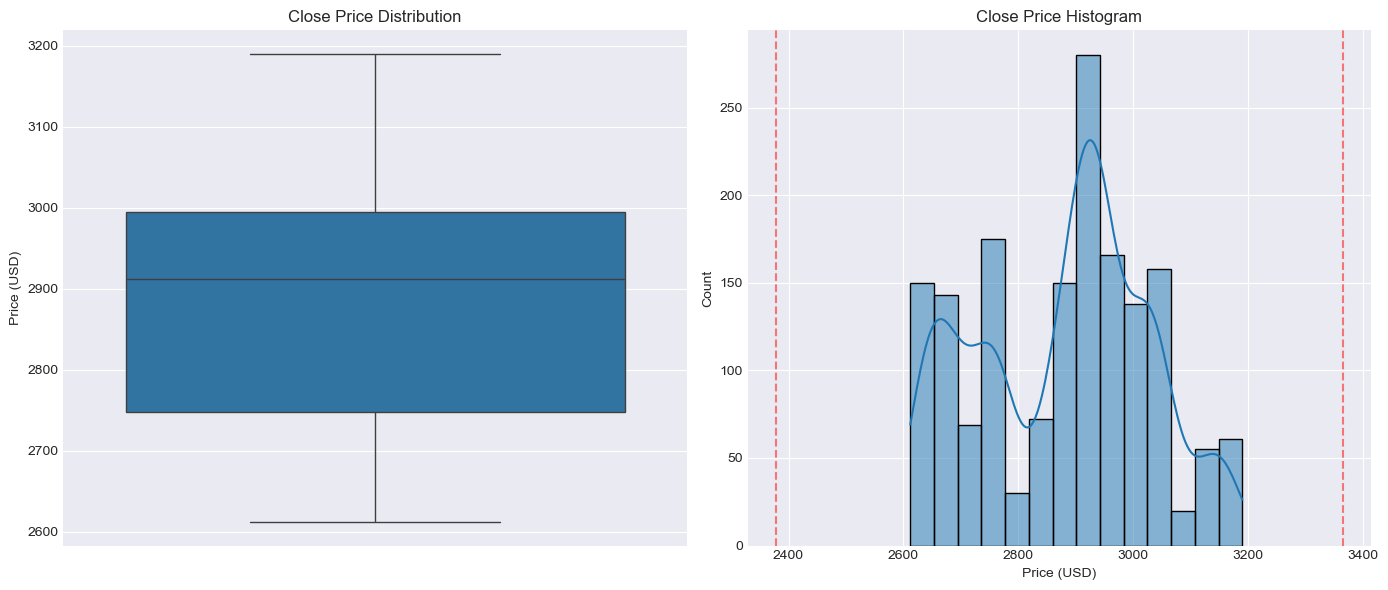


Extreme hourly returns detected: 24


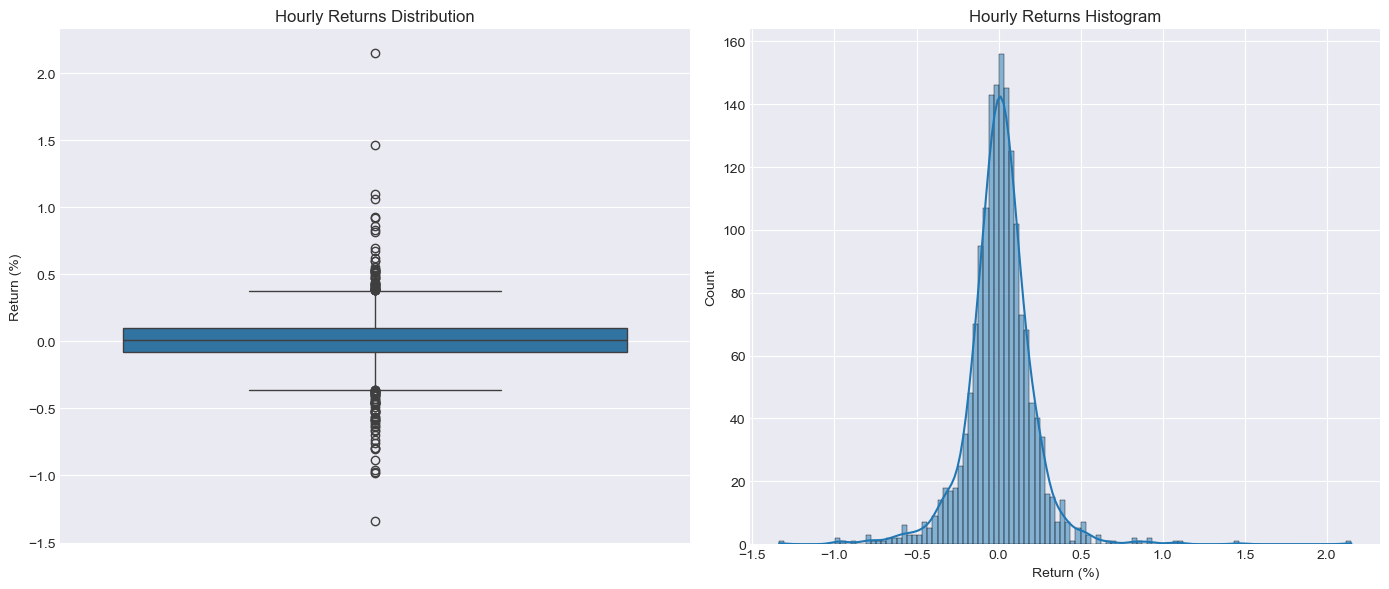

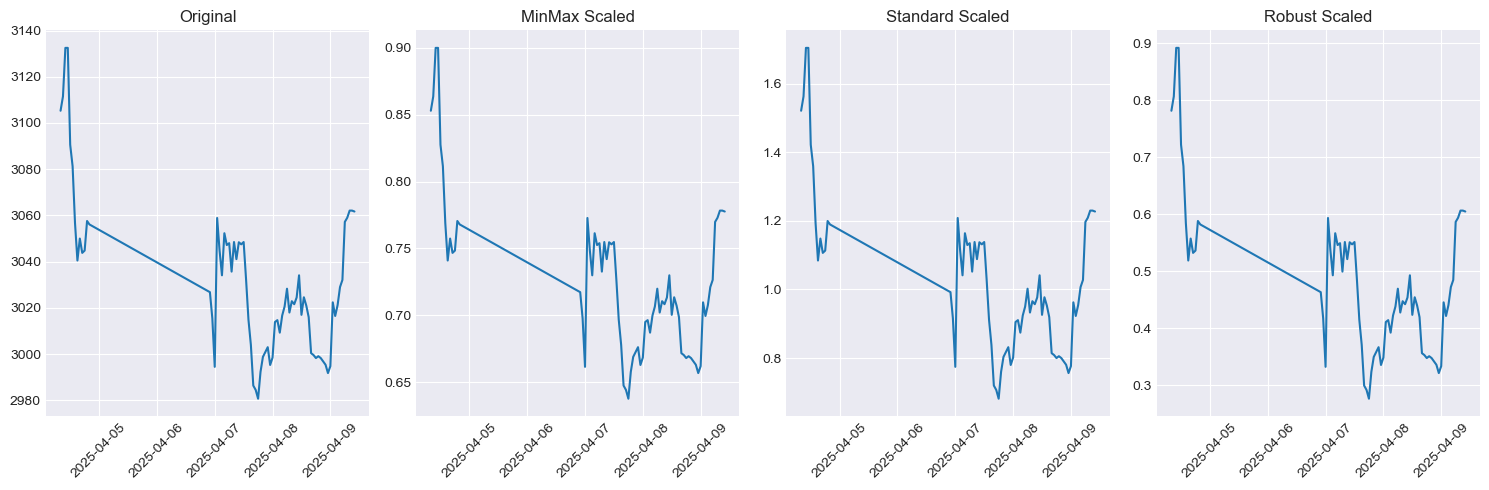

In [6]:
# Assign gold_futures data to gold_hourly for processing
gold_hourly = gold_futures.copy()

# Check basic information about our dataset
print("Dataset shape:", gold_hourly.shape)
print("\nData types:")
print(gold_hourly.dtypes)
print("\nBasic statistics:")
print(gold_hourly.describe())

# Check for missing values
print("\nMissing values:")
print(gold_hourly.isnull().sum())

# Forward fill any missing values (if they exist)
gold_hourly_cleaned = gold_hourly.fillna(method='ffill')

# Check for outliers using IQR method
def detect_outliers_iqr(df, column, threshold=1.5):
    """Detect outliers using the Interquartile Range (IQR) method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check for outliers in Close prices
close_outliers, lower_bound, upper_bound = detect_outliers_iqr(gold_hourly_cleaned, 'Close')
print(f"\nClose price outliers detected: {len(close_outliers)}")
print(f"IQR bounds: Lower ${lower_bound:.2f}, Upper ${upper_bound:.2f}")

# Visualize data distribution and outliers
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=gold_hourly_cleaned['Close'])
plt.title('Close Price Distribution')
plt.ylabel('Price (USD)')

plt.subplot(1, 2, 2)
sns.histplot(gold_hourly_cleaned['Close'], kde=True)
plt.title('Close Price Histogram')
plt.xlabel('Price (USD)')
plt.axvline(lower_bound, color='r', linestyle='--', alpha=0.5)
plt.axvline(upper_bound, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Calculate returns for additional analysis
gold_hourly_cleaned['Return'] = gold_hourly_cleaned['Close'].pct_change() * 100

# Check for extreme returns (potential data errors)
extreme_returns, ret_lower, ret_upper = detect_outliers_iqr(
    gold_hourly_cleaned.dropna(), 'Return', threshold=3.0
)
print(f"\nExtreme hourly returns detected: {len(extreme_returns)}")

# Visualize returns
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=gold_hourly_cleaned['Return'].dropna())
plt.title('Hourly Returns Distribution')
plt.ylabel('Return (%)')

plt.subplot(1, 2, 2)
sns.histplot(gold_hourly_cleaned['Return'].dropna(), kde=True)
plt.title('Hourly Returns Histogram')
plt.xlabel('Return (%)')

plt.tight_layout()
plt.show()

# Create different normalized versions of the data for experimentation
scalers = {
    'minmax': MinMaxScaler(feature_range=(0, 1)),
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

normalized_dfs = {}

for scaler_name, scaler in scalers.items():
    # Select numeric columns for scaling
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Create a copy of the dataframe
    scaled_df = gold_hourly_cleaned.copy()
    
    # Scale the selected columns
    scaled_values = scaler.fit_transform(scaled_df[numeric_cols])
    
    # Update the dataframe with scaled values
    for i, col in enumerate(numeric_cols):
        scaled_df[col] = scaled_values[:, i]
    
    # Store the scaled dataframe and scaler
    normalized_dfs[scaler_name] = {
        'data': scaled_df,
        'scaler': scaler
    }

# Visualize different normalization techniques
plt.figure(figsize=(15, 5))

# Original data
plt.subplot(1, 4, 1)
plt.plot(gold_hourly_cleaned['Close'][-72:])  # Last 72 hours (3 days)
plt.title('Original')
plt.xticks(rotation=45)

# MinMax scaled
plt.subplot(1, 4, 2)
plt.plot(normalized_dfs['minmax']['data']['Close'][-72:])
plt.title('MinMax Scaled')
plt.xticks(rotation=45)

# Standard scaled
plt.subplot(1, 4, 3)
plt.plot(normalized_dfs['standard']['data']['Close'][-72:])
plt.title('Standard Scaled')
plt.xticks(rotation=45)

# Robust scaled
plt.subplot(1, 4, 4)
plt.plot(normalized_dfs['robust']['data']['Close'][-72:])
plt.title('Robust Scaled')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Let's use MinMax scaling for our main analysis
gold_hourly_processed = gold_hourly_cleaned.copy()
price_scaler = scalers['minmax']

# Keep the original data for later reference
gold_hourly_original = gold_hourly_cleaned.copy()

## 4. Feature Engineering

Now we'll create advanced features including technical indicators, time-based features, volatility measures, and integrate external factors where possible.

In [7]:
def engineer_features(df):
    """
    Create advanced features for gold price prediction
    
    Parameters:
    df (pd.DataFrame): DataFrame with OHLCV data
    
    Returns:
    pd.DataFrame: DataFrame with additional engineered features
    """
    # Create a copy to avoid modifying the original
    enhanced_df = df.copy()
    
    # Make sure index is datetime
    if not isinstance(enhanced_df.index, pd.DatetimeIndex):
        enhanced_df.reset_index(inplace=True)
        enhanced_df['Date'] = pd.to_datetime(enhanced_df['Date'])
        enhanced_df.set_index('Date', inplace=True)
    
    # 1. Technical Indicators
    # -- Trend Indicators --
    # Simple Moving Averages
    enhanced_df['SMA_5'] = SMAIndicator(close=enhanced_df['Close'], window=5).sma_indicator()
    enhanced_df['SMA_20'] = SMAIndicator(close=enhanced_df['Close'], window=20).sma_indicator()
    enhanced_df['SMA_50'] = SMAIndicator(close=enhanced_df['Close'], window=50).sma_indicator()
    
    # Exponential Moving Averages
    enhanced_df['EMA_5'] = EMAIndicator(close=enhanced_df['Close'], window=5).ema_indicator()
    enhanced_df['EMA_20'] = EMAIndicator(close=enhanced_df['Close'], window=20).ema_indicator()
    
    # Moving Average Convergence Divergence
    macd = MACD(close=enhanced_df['Close'])
    enhanced_df['MACD'] = macd.macd()
    enhanced_df['MACD_Signal'] = macd.macd_signal()
    enhanced_df['MACD_Diff'] = macd.macd_diff()
    
    # -- Momentum Indicators --
    # Relative Strength Index
    enhanced_df['RSI'] = RSIIndicator(close=enhanced_df['Close']).rsi()
    
    # Stochastic Oscillator
    stoch = StochasticOscillator(
        high=enhanced_df['High'],
        low=enhanced_df['Low'],
        close=enhanced_df['Close']
    )
    enhanced_df['Stoch_%K'] = stoch.stoch()
    enhanced_df['Stoch_%D'] = stoch.stoch_signal()
    
    # -- Volatility Indicators --
    # Bollinger Bands
    bb = BollingerBands(close=enhanced_df['Close'])
    enhanced_df['BB_High'] = bb.bollinger_hband()
    enhanced_df['BB_Low'] = bb.bollinger_lband()
    enhanced_df['BB_Mid'] = bb.bollinger_mavg()
    enhanced_df['BB_Width'] = (enhanced_df['BB_High'] - enhanced_df['BB_Low']) / enhanced_df['BB_Mid']
    enhanced_df['BB_Pct'] = (enhanced_df['Close'] - enhanced_df['BB_Low']) / (enhanced_df['BB_High'] - enhanced_df['BB_Low'])
    
    # Average True Range (volatility)
    enhanced_df['ATR'] = AverageTrueRange(
        high=enhanced_df['High'],
        low=enhanced_df['Low'],
        close=enhanced_df['Close']
    ).average_true_range()
    
    # -- Volume Indicators --
    # On Balance Volume
    enhanced_df['OBV'] = OnBalanceVolumeIndicator(
        close=enhanced_df['Close'],
        volume=enhanced_df['Volume']
    ).on_balance_volume()
    
    # 2. Price-based features
    # Price changes
    enhanced_df['Price_Change'] = enhanced_df['Close'].diff()
    enhanced_df['Pct_Change'] = enhanced_df['Close'].pct_change() * 100
    
    # Return volatility using rolling window
    enhanced_df['Return_Volatility'] = enhanced_df['Pct_Change'].rolling(window=24).std()
    
    # Price ranges
    enhanced_df['Daily_Range'] = enhanced_df['High'] - enhanced_df['Low']
    enhanced_df['Daily_Range_Pct'] = enhanced_df['Daily_Range'] / enhanced_df['Open'] * 100
    
    # 3. Time-based features
    # Hour of day (cyclical encoding)
    enhanced_df['Hour'] = enhanced_df.index.hour
    enhanced_df['Hour_Sin'] = np.sin(2 * np.pi * enhanced_df['Hour'] / 24)
    enhanced_df['Hour_Cos'] = np.cos(2 * np.pi * enhanced_df['Hour'] / 24)
    
    # Day of week (cyclical encoding)
    enhanced_df['Weekday'] = enhanced_df.index.weekday
    enhanced_df['Weekday_Sin'] = np.sin(2 * np.pi * enhanced_df['Weekday'] / 7)
    enhanced_df['Weekday_Cos'] = np.cos(2 * np.pi * enhanced_df['Weekday'] / 7)
    
    # Month (cyclical encoding)
    enhanced_df['Month'] = enhanced_df.index.month
    enhanced_df['Month_Sin'] = np.sin(2 * np.pi * enhanced_df['Month'] / 12)
    enhanced_df['Month_Cos'] = np.cos(2 * np.pi * enhanced_df['Month'] / 12)
    
    # Trading session features (based on common gold trading hours)
    # - Asian session: 0-8 UTC
    # - European session: 8-16 UTC
    # - US session: 13-21 UTC
    enhanced_df['Asian_Session'] = (enhanced_df['Hour'] >= 0) & (enhanced_df['Hour'] < 8)
    enhanced_df['Europe_Session'] = (enhanced_df['Hour'] >= 8) & (enhanced_df['Hour'] < 16)
    enhanced_df['US_Session'] = (enhanced_df['Hour'] >= 13) & (enhanced_df['Hour'] < 21)
    enhanced_df['Overlap_Session'] = (enhanced_df['Hour'] >= 13) & (enhanced_df['Hour'] < 16)
    
    # 4. Lagged features
    for lag in [1, 3, 6, 12, 24]:  # 1 hour, 3 hours, 6 hours, 12 hours, 1 day
        enhanced_df[f'Close_Lag_{lag}'] = enhanced_df['Close'].shift(lag)
        enhanced_df[f'Return_Lag_{lag}'] = enhanced_df['Pct_Change'].shift(lag)
    
    # 5. Rolling window statistics
    for window in [6, 12, 24]:  # 6 hours, 12 hours, 1 day
        # Mean and standard deviation
        enhanced_df[f'Close_Rolling_Mean_{window}'] = enhanced_df['Close'].rolling(window=window).mean()
        enhanced_df[f'Close_Rolling_Std_{window}'] = enhanced_df['Close'].rolling(window=window).std()
        
        # Min and Max
        enhanced_df[f'Close_Rolling_Min_{window}'] = enhanced_df['Close'].rolling(window=window).min()
        enhanced_df[f'Close_Rolling_Max_{window}'] = enhanced_df['Close'].rolling(window=window).max()
        
        # Range within window
        enhanced_df[f'Close_Rolling_Range_{window}'] = (
            enhanced_df[f'Close_Rolling_Max_{window}'] - enhanced_df[f'Close_Rolling_Min_{window}']
        )
    
    # 6. Momentum and trend features
    # Rate of Change
    for window in [6, 12, 24]:
        enhanced_df[f'ROC_{window}'] = (
            (enhanced_df['Close'] - enhanced_df['Close'].shift(window)) / 
            enhanced_df['Close'].shift(window) * 100
        )
    
    # Above/Below Moving Average signals
    enhanced_df['Above_SMA_20'] = (enhanced_df['Close'] > enhanced_df['SMA_20']).astype(int)
    enhanced_df['Above_SMA_50'] = (enhanced_df['Close'] > enhanced_df['SMA_50']).astype(int)
    
    # Moving Average Crossovers
    enhanced_df['SMA_5_20_Crossover'] = (
        (enhanced_df['SMA_5'] > enhanced_df['SMA_20']) & 
        (enhanced_df['SMA_5'].shift(1) <= enhanced_df['SMA_20'].shift(1))
    ).astype(int)
    
    enhanced_df['SMA_20_50_Crossover'] = (
        (enhanced_df['SMA_20'] > enhanced_df['SMA_50']) & 
        (enhanced_df['SMA_20'].shift(1) <= enhanced_df['SMA_50'].shift(1))
    ).astype(int)
    
    # Drop rows with NaN values that result from indicators calculation
    enhanced_df = enhanced_df.dropna()
    
    return enhanced_df

# Apply feature engineering to our dataset
gold_hourly_features = engineer_features(gold_hourly_original)

# Print overview of engineered features
print(f"Original data shape: {gold_hourly_original.shape}")
print(f"Feature-engineered data shape: {gold_hourly_features.shape}")
print(f"Created {gold_hourly_features.shape[1] - gold_hourly_original.shape[1]} new features")

# Show the first few rows of the feature-engineered dataset
gold_hourly_features.tail()

Original data shape: (1667, 7)
Feature-engineered data shape: (1618, 75)
Created 68 new features


,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_20,SMA_50,EMA_5,EMA_20,MACD,MACD_Signal,MACD_Diff,RSI,Stoch_%K,Stoch_%D,BB_High,BB_Low,BB_Mid,BB_Width,BB_Pct,ATR,OBV,Price_Change,Pct_Change,Return_Volatility,Daily_Range,Daily_Range_Pct,Hour,Hour_Sin,Hour_Cos,Weekday,Weekday_Sin,Weekday_Cos,Month,Month_Sin,Month_Cos,Asian_Session,Europe_Session,US_Session,Overlap_Session,Close_Lag_1,Return_Lag_1,Close_Lag_3,Return_Lag_3,Close_Lag_6,Return_Lag_6,Close_Lag_12,Return_Lag_12,Close_Lag_24,Return_Lag_24,Close_Rolling_Mean_6,Close_Rolling_Std_6,Close_Rolling_Min_6,Close_Rolling_Max_6,Close_Rolling_Range_6,Close_Rolling_Mean_12,Close_Rolling_Std_12,Close_Rolling_Min_12,Close_Rolling_Max_12,Close_Rolling_Range_12,Close_Rolling_Mean_24,Close_Rolling_Std_24,Close_Rolling_Min_24,Close_Rolling_Max_24,Close_Rolling_Range_24,ROC_6,ROC_12,ROC_24,Above_SMA_20,Above_SMA_50,SMA_5_20_Crossover,SMA_20_50_Crossover
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-04-09 06:00:00+00:00,3032.3000,3058.8000,3026.2000,3057.2000,16719,GC=F,0.8278,3031.2000,3014.6650,3018.0280,3034.3310,3018.1955,3.8268,-1.9459,5.7726,68.5182,98.2795,93.8407,3047.9577,2981.3723,3014.6650,0.0221,1.1388,24.7668,531654,25.0999,0.8278,0.3400,32.6001,1.0751,6,1.0000,0.0000,2,0.9749,-0.2225,4,0.8660,-0.5000,True,False,False,False,3032.1001,0.1023,3021.2000,0.1558,2994.8000,0.1003,2999.6001,-0.0267,3020.6001,0.1293,3029.7333,14.5758,3016.5000,3057.2000,40.7000,3013.0083,20.1317,2991.8000,3057.2000,65.3999,3016.0042,15.8963,2991.8000,3057.2000,65.3999,2.0836,1.9203,1.2117,1,1,0,0
2025-04-09 07:00:00+00:00,3057.1001,3071.3999,3051.6001,3059.0000,13682,GC=F,0.0589,3039.7000,3016.3900,3018.5260,3042.5540,3022.0816,6.5057,-0.2556,6.7612,69.0467,88.2577,92.3703,3054.7342,2978.0459,3016.3900,0.0254,1.0556,24.4120,545336,1.8000,0.0589,0.3373,19.7998,0.6477,7,0.9659,-0.2588,2,0.9749,-0.2225,4,0.8660,-0.5000,True,False,False,False,3057.2000,0.8278,3029.0000,0.2582,3022.3999,0.9216,2998.3000,-0.0433,3028.3000,0.2549,3035.8333,18.1206,3016.5000,3059.0000,42.5000,3018.0667,23.4520,2991.8000,3059.0000,67.2000,3017.2833,18.0219,2991.8000,3059.0000,67.2000,1.2110,2.0245,1.0138,1,1,0,0
2025-04-09 08:00:00+00:00,3059.1001,3069.2000,3046.7000,3062.1001,8329,GC=F,0.1013,3047.8800,3017.7900,3018.7220,3049.0694,3025.8929,8.7777,1.5511,7.2266,69.9814,91.1934,92.5768,3060.4232,2975.1568,3017.7900,0.0283,1.0197,24.2754,553665,3.1001,0.1013,0.3274,22.5000,0.7355,8,0.8660,-0.5000,2,0.9749,-0.2225,4,0.8660,-0.5000,False,True,False,False,3059.0000,0.0589,3032.1001,0.1023,3016.5000,-0.1952,2999.1001,0.0267,3018.0000,-0.3401,3043.4333,17.9520,3021.2000,3062.1001,40.9001,3023.3167,25.7584,2991.8000,3062.1001,70.3000,3019.1208,20.2131,2991.8000,3062.1001,70.3000,1.5117,2.1006,1.4612,1,1,0,0
2025-04-09 09:00:00+00:00,3062.1001,3067.6001,3057.3999,3062.1001,6379,GC=F,0.0000,3054.5000,3020.0450,3019.0200,3053.4130,3029.3412,10.4577,3.3324,7.1253,69.9814,91.1934,90.2148,3066.8403,2973.2497,3020.0450,0.0310,0.9494,23.2701,560044,0.0000,0.0000,0.3269,10.2002,0.3331,9,0.7071,-0.7071,2,0.9749,-0.2225,4,0.8660,-0.5000,False,True,False,False,3062.1001,0.1013,3057.2000,0.8278,3021.2000,0.1558,2998.3000,-0.0267,3022.8999,0.1624,3050.2500,15.4058,3029.0000,3062.1001,33.1001,3028.6333,26.6928,2991.8000,3062.1001,70.3000,3020.7542,22.0336,2991.8000,3062.1001,70.3000,1.3538,2.1279,1.2968,1,1,0,1
2025-04-09 10:00:00+00:00,3062.0000,3064.7000,3055.2000,3061.7000,6229,GC=F,-0.0131,3060.4200,3021.9000,3019.2940,3056.1753,3032.4230,11.6229,4.9905,6.6324,69.6665,90.8144,91.0670,3072.0888,2971.7112,3021.9000,0.0332,0.8965,22.2865,553815,-0.4001,-0.0131,0.3265,9.5000,0.3103,10,0.5000,-0.8660,2,0.9749,-0.2225,4,0.8660,-0.5000,False,True,False,False,3062.1001,0.0000,3059.0000,0.0589,3029.0000,0.2582,2995.3999,-0.0967,3021.6001,-0.0430,3055.7000,11.7304,3032.1001,3062.1001,30.0000,3034.1583,26.0423,2991.8000,3062.1001,70.3000,3022.4250,23.5675,2991.8000,3062.1001,70.3000,1.0796,2.2134,1.3271,1,1

## 5. Exploratory Data Analysis

Now we'll perform a comprehensive analysis of hourly patterns, discover correlations between features, and identify key seasonal patterns that might affect prediction accuracy.

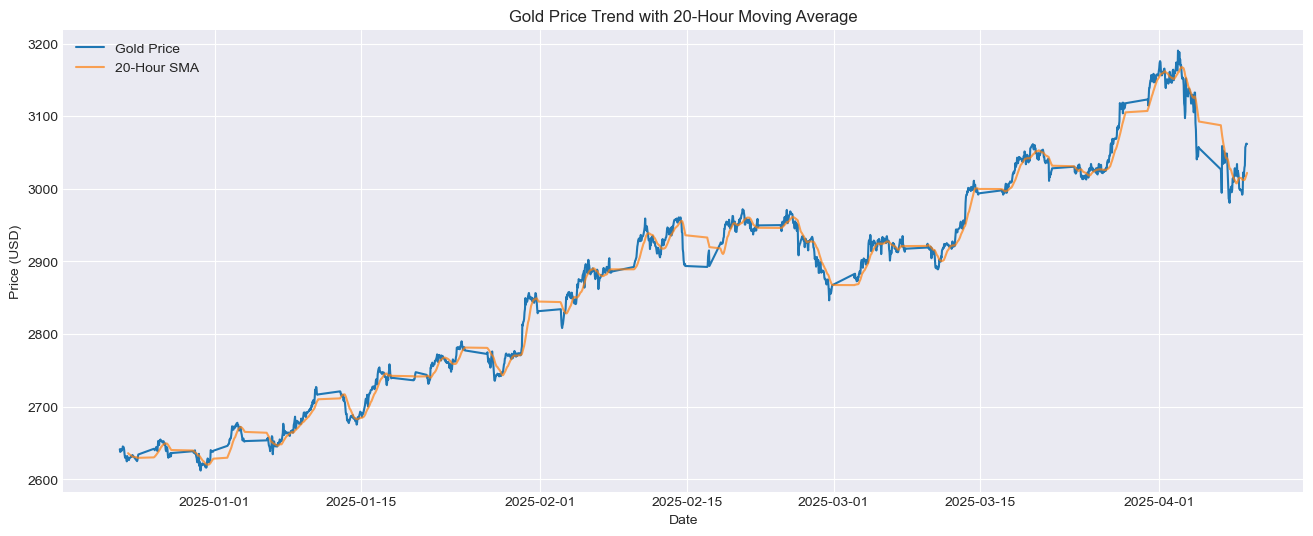

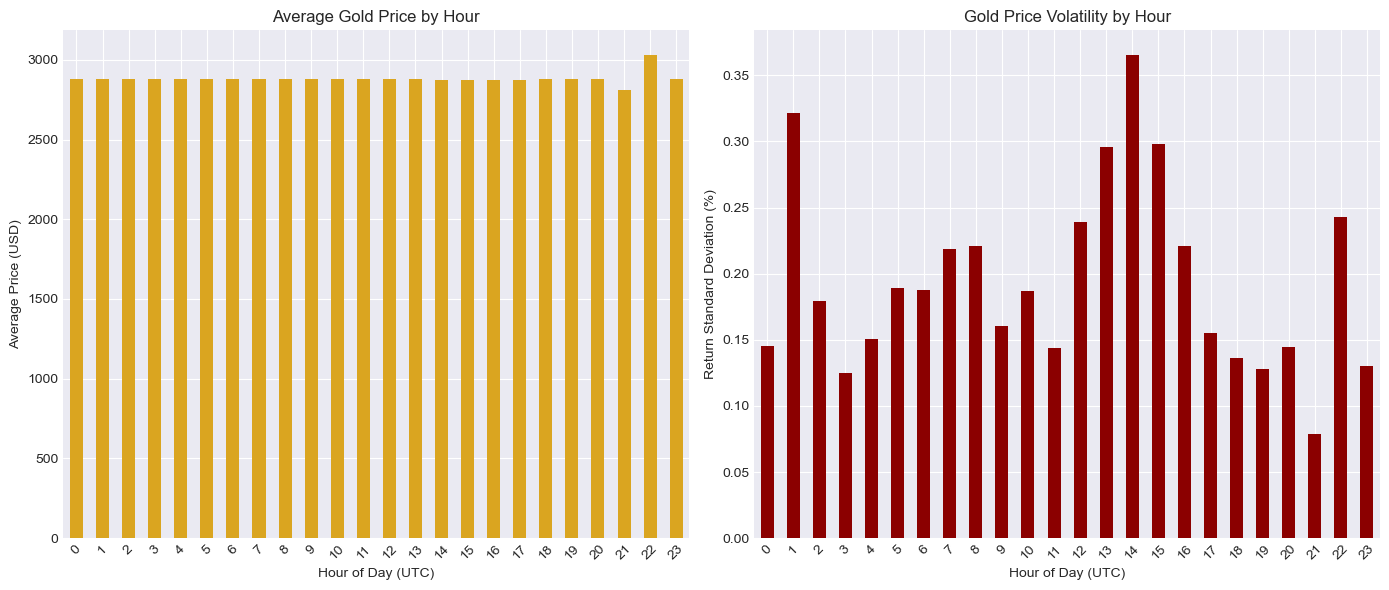

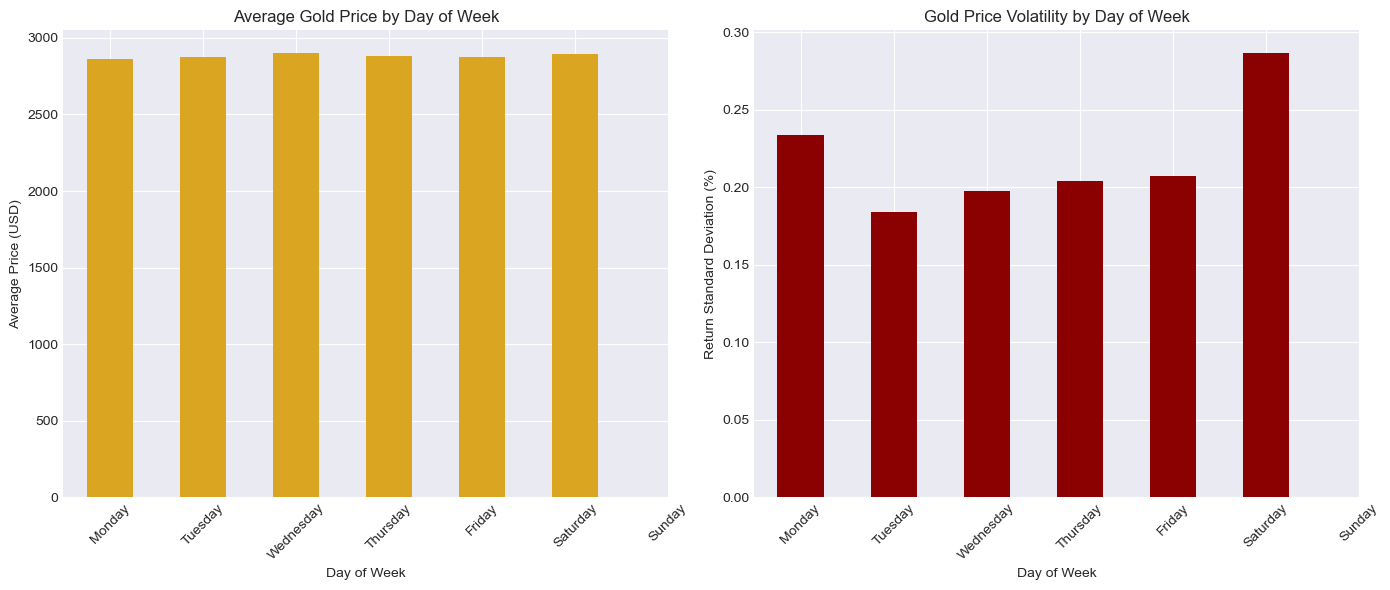

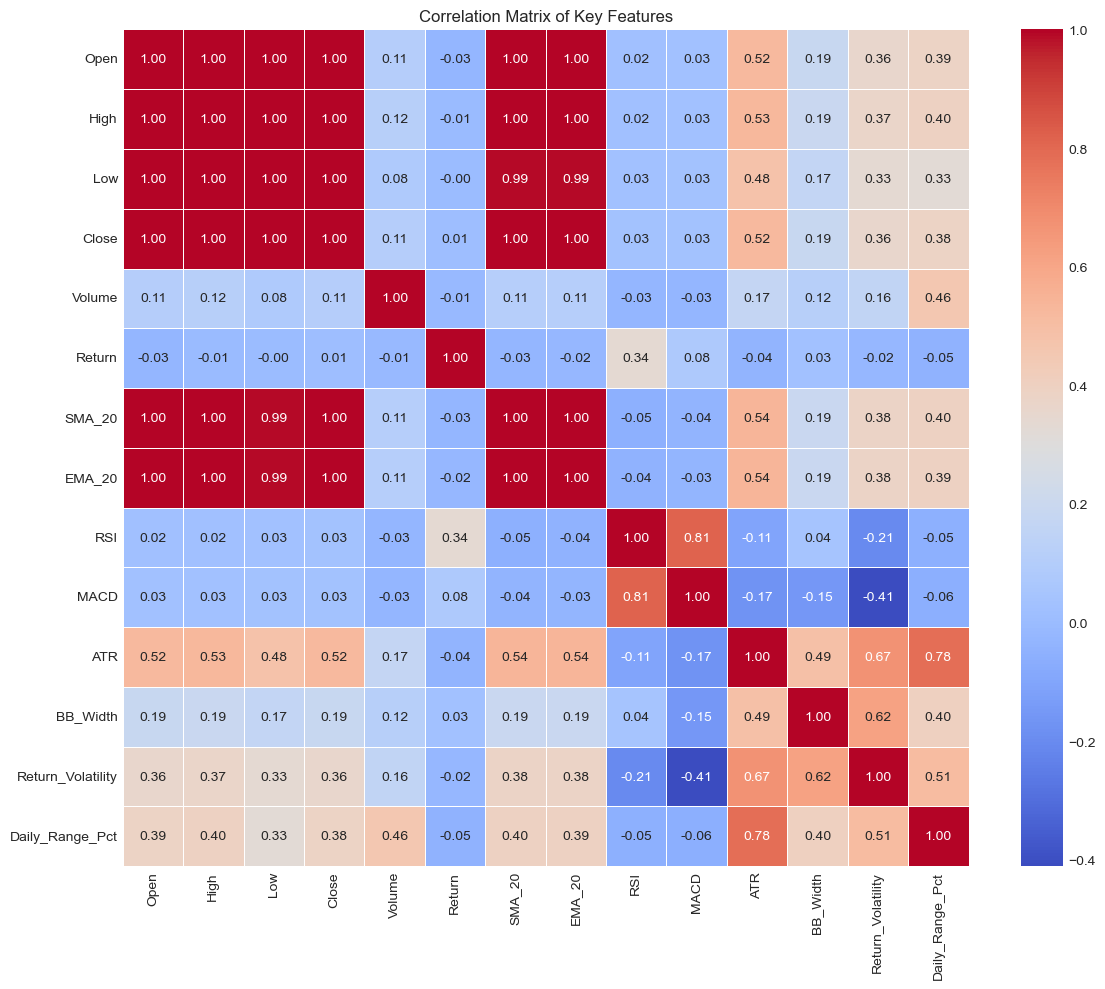

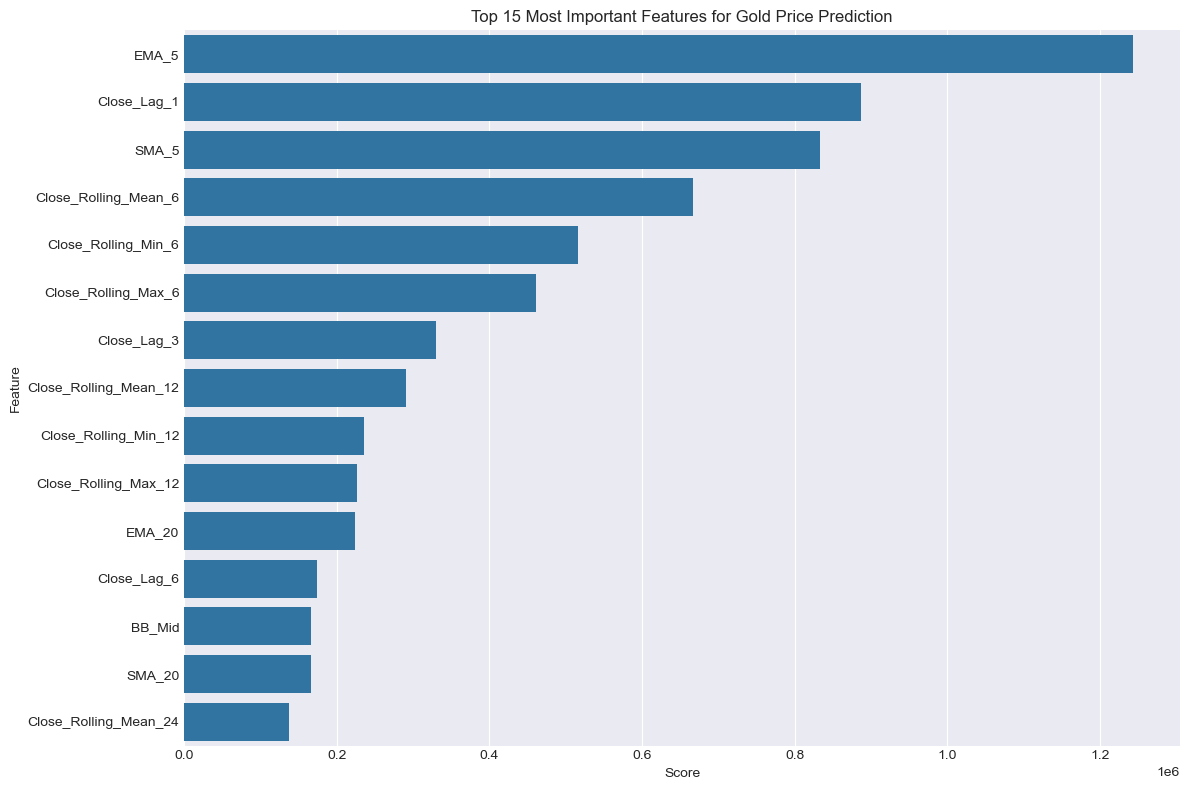

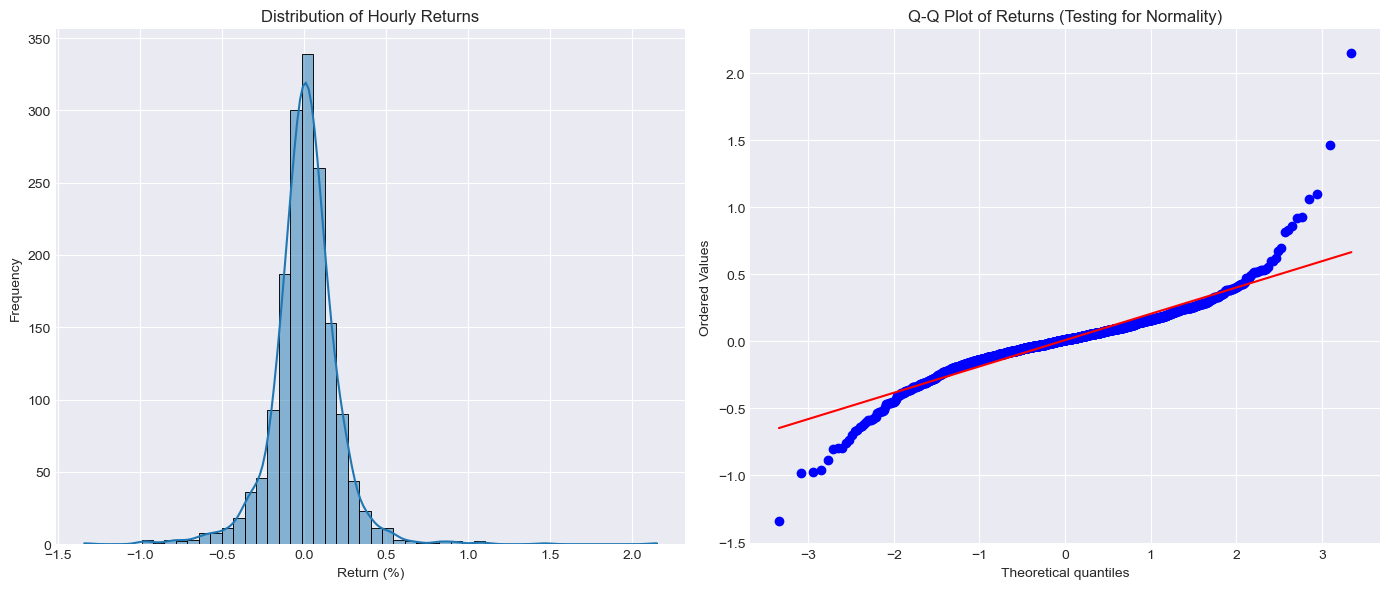

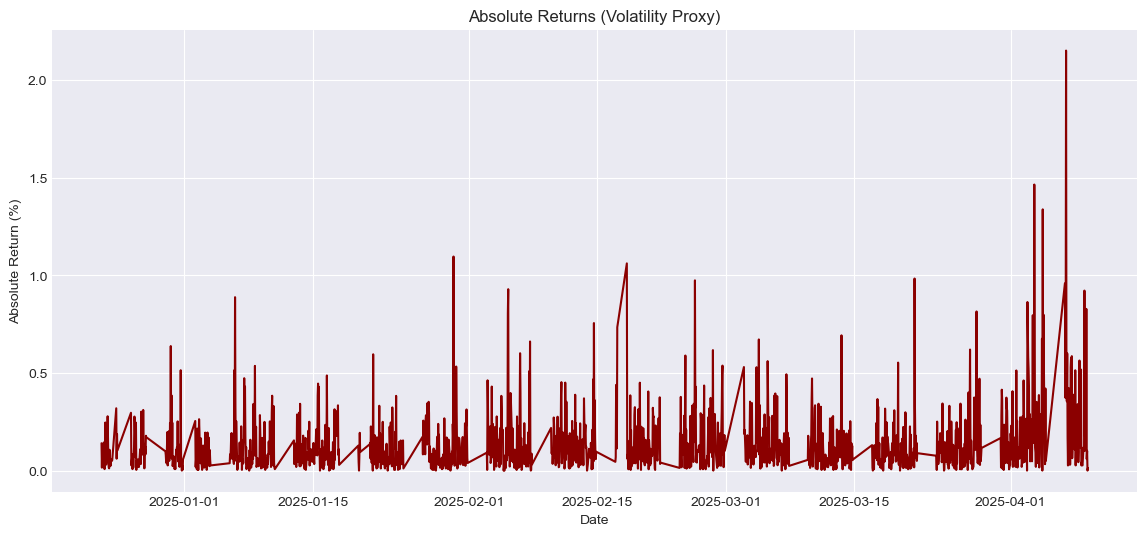

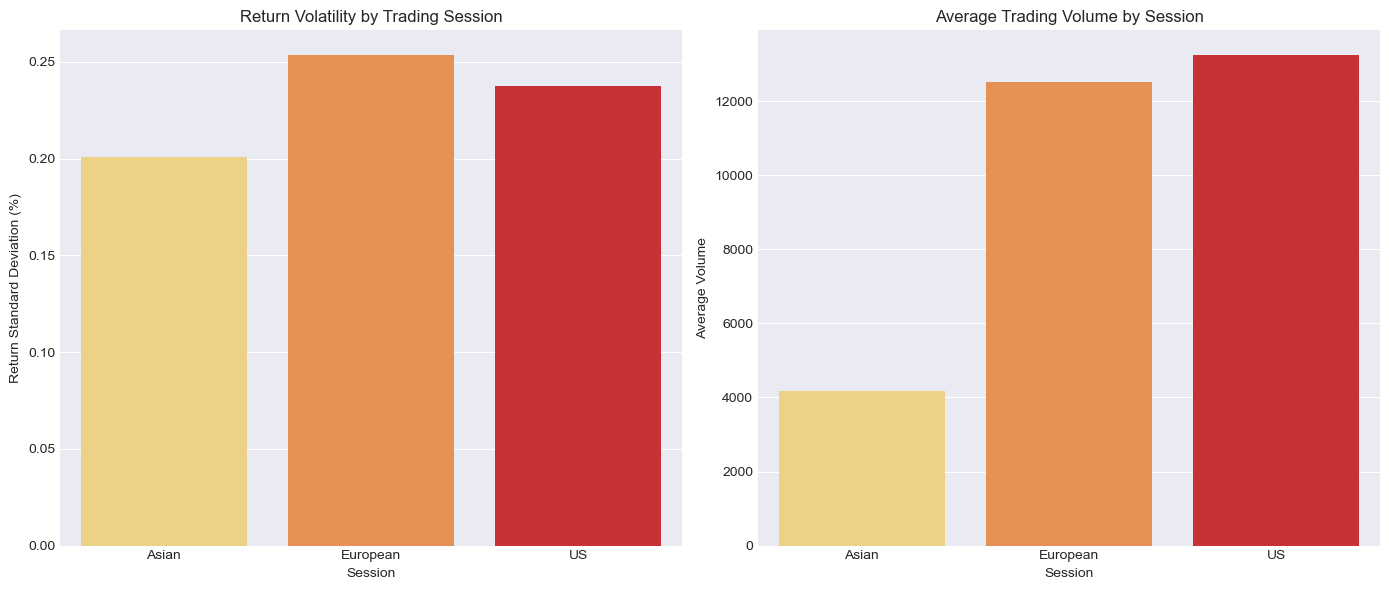

In [8]:
# 1. Visualize the gold price trend
plt.figure(figsize=(16, 6))
plt.plot(gold_hourly_original.index, gold_hourly_original['Close'], label='Gold Price')
plt.plot(gold_hourly_original.index, gold_hourly_original['SMA_20'] 
         if 'SMA_20' in gold_hourly_original.columns 
         else SMAIndicator(close=gold_hourly_original['Close'], window=20).sma_indicator(), 
         label='20-Hour SMA', alpha=0.7)
plt.title('Gold Price Trend with 20-Hour Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Analyze hourly patterns
hourly_avg = gold_hourly_original.groupby(gold_hourly_original.index.hour)['Close'].mean()
hourly_volatility = gold_hourly_original.groupby(gold_hourly_original.index.hour)['Return'].std()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
hourly_avg.plot(kind='bar', color='goldenrod')
plt.title('Average Gold Price by Hour')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
hourly_volatility.plot(kind='bar', color='darkred')
plt.title('Gold Price Volatility by Hour')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Return Standard Deviation (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 3. Analyze day of week patterns
weekday_avg = gold_hourly_original.groupby(gold_hourly_original.index.weekday)['Close'].mean()
weekday_volatility = gold_hourly_original.groupby(gold_hourly_original.index.weekday)['Return'].std()
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
weekday_avg.plot(kind='bar', color='goldenrod')
plt.title('Average Gold Price by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Price (USD)')
plt.xticks(range(7), weekday_names, rotation=45)

plt.subplot(1, 2, 2)
weekday_volatility.plot(kind='bar', color='darkred')
plt.title('Gold Price Volatility by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Return Standard Deviation (%)')
plt.xticks(range(7), weekday_names, rotation=45)

plt.tight_layout()
plt.show()

# 4. Correlation analysis of engineered features
# Select a subset of important features to avoid cluttering the correlation matrix
selected_features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'Return', 
    'SMA_20', 'EMA_20', 'RSI', 'MACD', 'ATR', 'BB_Width', 
    'Return_Volatility', 'Daily_Range_Pct'
]

# Make sure all selected features are in our dataframe
available_features = [f for f in selected_features if f in gold_hourly_features.columns]
correlation_matrix = gold_hourly_features[available_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.show()

# 5. Feature importance analysis using SelectKBest
# Prepare X and y for feature importance
X = gold_hourly_features.drop(['Close', 'Open', 'High', 'Low'], axis=1)
y = gold_hourly_features['Close']

# Remove non-numeric columns for feature selection
X_numeric = X.select_dtypes(include=[np.number])

# Use SelectKBest to find top features
k_best = min(20, X_numeric.shape[1])
selector = SelectKBest(score_func=f_regression, k=k_best)
selector.fit(X_numeric, y)

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': X_numeric.columns,
    'Score': selector.scores_
})

# Sort by importance
feature_scores = feature_scores.sort_values('Score', ascending=False)

# Visualize top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(15))
plt.title('Top 15 Most Important Features for Gold Price Prediction')
plt.tight_layout()
plt.show()

# 6. Return distribution analysis
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(gold_hourly_original['Return'].dropna(), kde=True, bins=50)
plt.title('Distribution of Hourly Returns')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(gold_hourly_original['Return'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Returns (Testing for Normality)')

plt.tight_layout()
plt.show()

# 7. Volatility clustering - GARCH effects
plt.figure(figsize=(14, 6))
plt.plot(gold_hourly_original.index, gold_hourly_original['Return'].abs(), color='darkred')
plt.title('Absolute Returns (Volatility Proxy)')
plt.xlabel('Date')
plt.ylabel('Absolute Return (%)')
plt.grid(True)
plt.show()

# 8. Trading session analysis
plt.figure(figsize=(14, 6))

# Create session indicators if they don't exist
if 'Asian_Session' not in gold_hourly_features.columns:
    gold_hourly_features['Asian_Session'] = (gold_hourly_features.index.hour >= 0) & (gold_hourly_features.index.hour < 8)
    gold_hourly_features['Europe_Session'] = (gold_hourly_features.index.hour >= 8) & (gold_hourly_features.index.hour < 16)
    gold_hourly_features['US_Session'] = (gold_hourly_features.index.hour >= 13) & (gold_hourly_features.index.hour < 21)

session_volatility = pd.DataFrame({
    'Session': ['Asian', 'European', 'US'],
    'Return_Std': [
        gold_hourly_features.loc[gold_hourly_features['Asian_Session']]['Return'].std(),
        gold_hourly_features.loc[gold_hourly_features['Europe_Session']]['Return'].std(),
        gold_hourly_features.loc[gold_hourly_features['US_Session']]['Return'].std(),
    ],
    'Volume_Mean': [
        gold_hourly_features.loc[gold_hourly_features['Asian_Session']]['Volume'].mean(),
        gold_hourly_features.loc[gold_hourly_features['Europe_Session']]['Volume'].mean(),
        gold_hourly_features.loc[gold_hourly_features['US_Session']]['Volume'].mean(),
    ]
})

plt.subplot(1, 2, 1)
sns.barplot(x='Session', y='Return_Std', data=session_volatility, palette='YlOrRd')
plt.title('Return Volatility by Trading Session')
plt.ylabel('Return Standard Deviation (%)')

plt.subplot(1, 2, 2)
sns.barplot(x='Session', y='Volume_Mean', data=session_volatility, palette='YlOrRd')
plt.title('Average Trading Volume by Session')
plt.ylabel('Average Volume')

plt.tight_layout()
plt.show()

## 6. Multiple Model Implementation

We'll implement and compare multiple deep learning architectures including Bidirectional LSTM, GRU, CNN-LSTM hybrid, and Transformer models with attention mechanisms.

X_train shape: (1115, 24, 16)
y_train shape: (1115,)
X_val shape: (239, 24, 16)
y_val shape: (239,)
X_test shape: (240, 24, 16)
y_test shape: (240,)
Input shape: (24, 16)
Training LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        13,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,651 (131.45 KB)

 Trainable params: 33,651 (131.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0643 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0045 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 10/50
35/35 ━

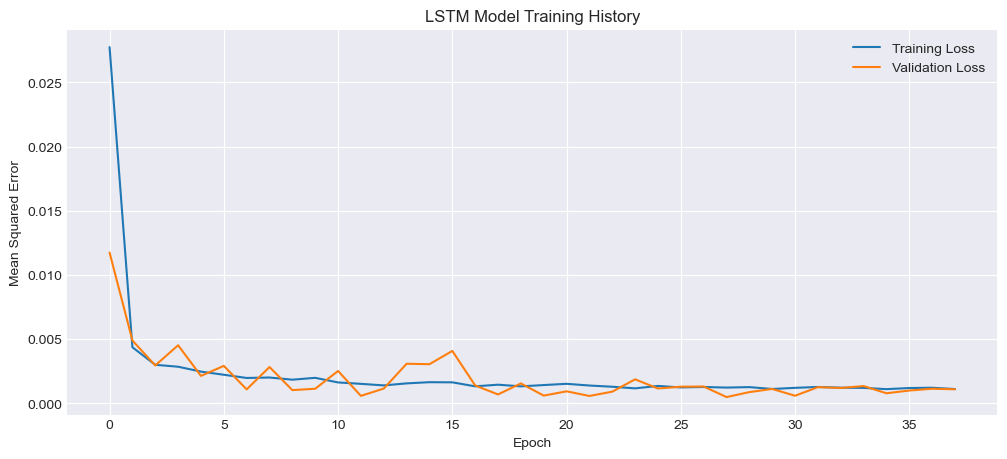

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Model: LSTM
Root Mean Squared Error (RMSE): 46.8784
Mean Absolute Error (MAE): 40.3859
R² Score: 0.3771


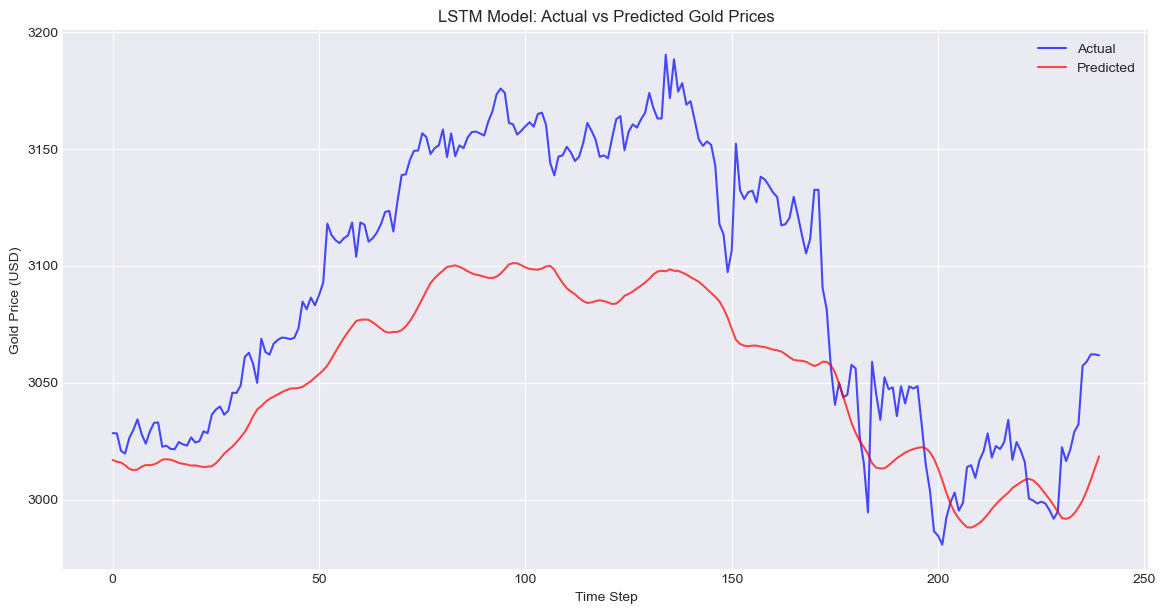

Trenowanie wszystkich modeli...

=== Trenowanie modelu LSTM ===
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 0.0010 - learning_rate: 3.1250e-05
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 7.3818e-04 - learning_rate: 3.1250e-05
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 0.0011 - learning_rate: 3.1250e-05
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 0.0013 - learning_rate: 3.1250e-05
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 0.0013 - learning_rate: 3.1250e-05
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0010 - learning_rate: 3.1250e-05
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 0.0013 - learning_rate: 3.1250e-05
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0013 - learning_rate: 1.5625e-05
Epoch 9/50
35/35 ━━━━━━━━━━━

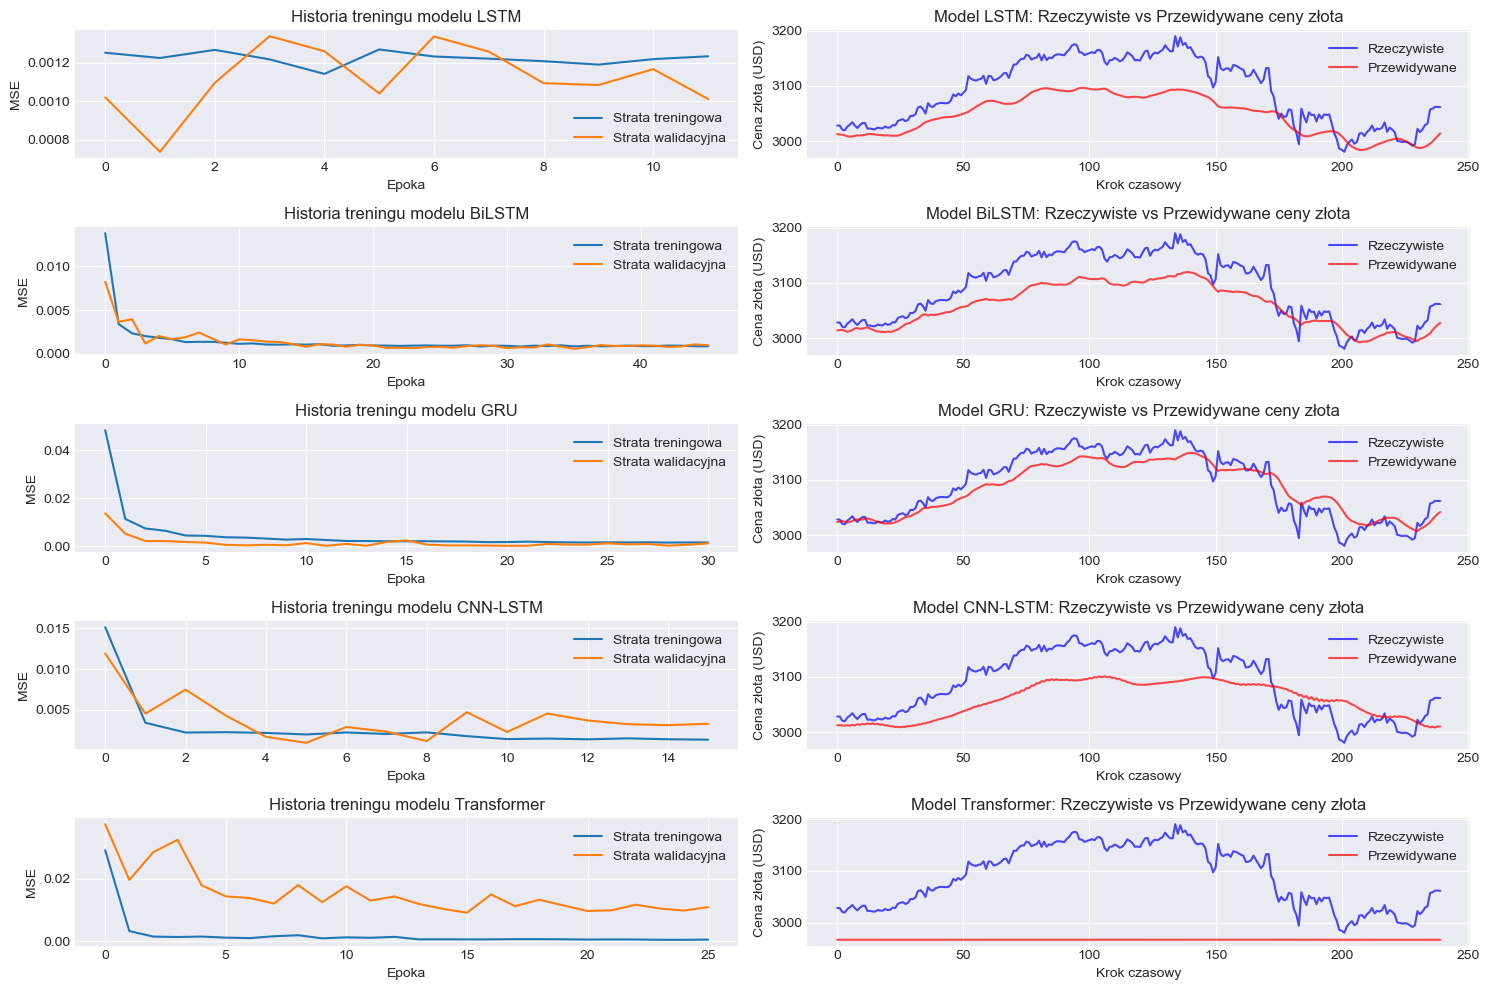

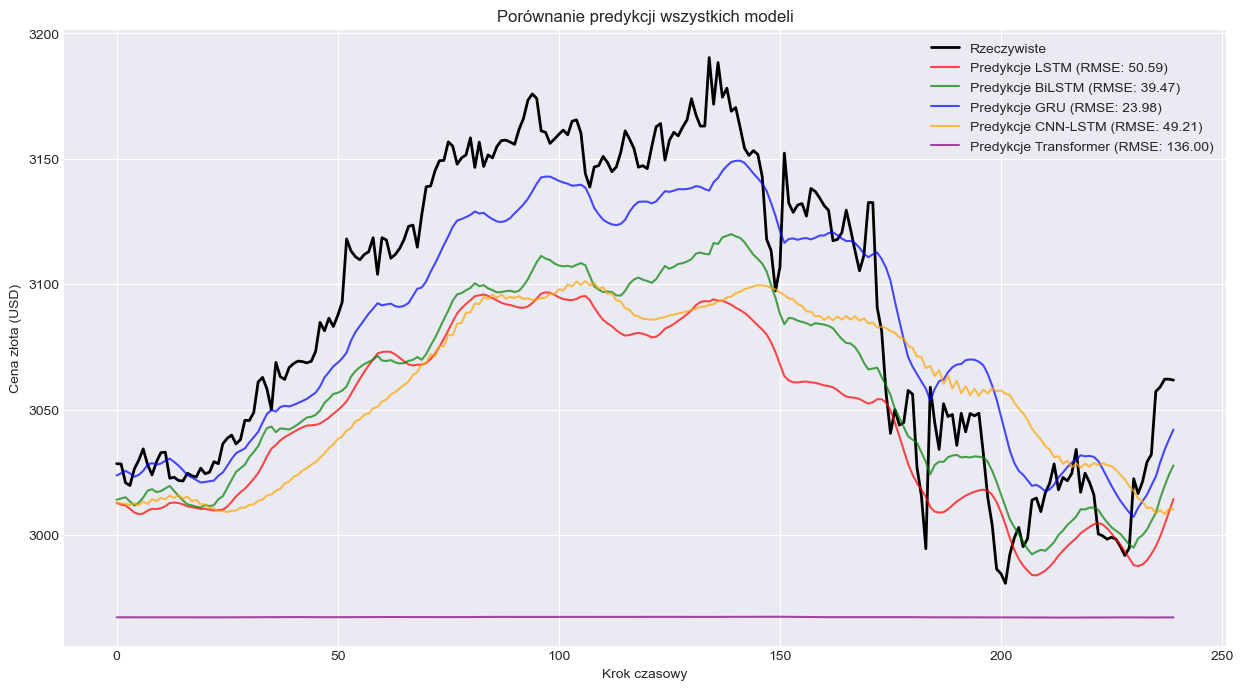

Model LSTM zapisany do pliku model_LSTM.h5
Model BiLSTM zapisany do pliku model_BiLSTM.h5
Model GRU zapisany do pliku model_GRU.h5
Model CNN-LSTM zapisany do pliku model_CNN-LSTM.h5
Model Transformer zapisany do pliku model_Transformer.h5

Gotowość do przeprowadzania predykcji z wykorzystaniem wielu modeli na następne 24h.
Aby uruchomić predykcję na najnowszych danych wywołaj funkcję:
all_predictions = predict_next_24h_with_all_models(latest_gold_data, models, sequence_data)


In [9]:
# Data preparation function for sequence models
def prepare_sequence_data(data, target_col='Close', feature_cols=None, 
                          sequence_length=24, forecast_horizon=1, 
                          train_split=0.8, val_split=0.1):
    """
    Prepare sequence data for deep learning models
    
    Parameters:
    data (pd.DataFrame): Feature-engineered dataframe
    target_col (str): Target column to predict
    feature_cols (list): List of feature columns to use (if None, use all numeric columns)
    sequence_length (int): Number of time steps in each sequence
    forecast_horizon (int): Number of steps ahead to predict
    train_split (float): Proportion of data for training
    val_split (float): Proportion of data for validation
    
    Returns:
    dict: Dictionary with X_train, y_train, X_val, y_val, X_test, y_test and scalers
    """
    # If no feature columns specified, use all numeric columns
    if feature_cols is None:
        feature_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        # Exclude the target from features if it's in the list
        if target_col in feature_cols:
            feature_cols.remove(target_col)
    
    # Make sure the target is included in the data we'll scale
    all_cols = feature_cols + [target_col] if target_col not in feature_cols else feature_cols.copy()
    
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[all_cols])
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length - forecast_horizon + 1):
        # Extract sequence of features
        seq = scaled_data[i:i+sequence_length, :]
        X.append(seq)
        
        # Extract target value (forecast_horizon steps ahead)
        target_index = all_cols.index(target_col) if target_col in all_cols else -1
        target = scaled_data[i+sequence_length+forecast_horizon-1, target_index]
        y.append(target)
    
    X = np.array(X)
    y = np.array(y)
    
    # Split into train, validation, and test sets
    train_size = int(len(X) * train_split)
    val_size = int(len(X) * val_split)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    
    # Create a scaler for the target column only (for inverse transformation)
    target_scaler = MinMaxScaler()
    target_scaler.fit_transform(data[[target_col]].values)
    
    result = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'feature_cols': feature_cols,
        'scaler': scaler,
        'target_scaler': target_scaler,
        'target_col': target_col,
        'sequence_length': sequence_length,
        'forecast_horizon': forecast_horizon,
    }
    
    return result

# Define model architectures
def create_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2):
    """Simple LSTM model architecture"""
    model = Sequential([
        LSTM(units=lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units=lstm_units),
        Dropout(dropout_rate),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_bilstm_model(input_shape, lstm_units=50, dropout_rate=0.2):
    """Bidirectional LSTM model architecture"""
    model = Sequential([
        Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=input_shape),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units=lstm_units)),
        Dropout(dropout_rate),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_gru_model(input_shape, gru_units=50, dropout_rate=0.2):
    """GRU model architecture"""
    model = Sequential([
        GRU(units=gru_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        GRU(units=gru_units),
        Dropout(dropout_rate),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_cnn_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2):
    """CNN-LSTM hybrid model architecture"""
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        LSTM(units=lstm_units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units=lstm_units),
        Dropout(dropout_rate),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_transformer_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, dropout_rate=0.2):
    """Transformer model with attention mechanism"""
    inputs = Input(shape=input_shape)
    x = inputs
    
    # Add transformer blocks
    for _ in range(num_transformer_blocks):
        # Multi-head attention
        attention_output = MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout_rate
        )(x, x)
        x = LayerNormalization(epsilon=1e-6)(attention_output + x)
        
        # Feed-forward network
        ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(input_shape[-1]),
        ])
        x = ffn(x)
        x = LayerNormalization(epsilon=1e-6)(x)
    
    # Global average pooling
    x = GlobalAveragePooling1D()(x)
    
    # Output layer
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Prepare sequence data for modeling
# Select a subset of the most important features based on earlier analysis
important_features = [
    'Close', 'SMA_5', 'SMA_20', 'EMA_5', 'RSI', 'MACD', 
    'ATR', 'BB_Width', 'Return_Volatility', 'Pct_Change',
    'Close_Lag_1', 'Close_Lag_3', 'Hour_Sin', 'Hour_Cos',
    'Weekday_Sin', 'Weekday_Cos'
]

# Ensure we're only using features that are in our dataset
available_features = [f for f in important_features if f in gold_hourly_features.columns]

sequence_data = prepare_sequence_data(
    data=gold_hourly_features,
    target_col='Close',
    feature_cols=available_features,
    sequence_length=24,  # Use 24 hours (1 day) of data to predict
    forecast_horizon=1,  # Predict 1 hour ahead
    train_split=0.7,
    val_split=0.15
)

# Print shapes of prepared data
print(f"X_train shape: {sequence_data['X_train'].shape}")
print(f"y_train shape: {sequence_data['y_train'].shape}")
print(f"X_val shape: {sequence_data['X_val'].shape}")
print(f"y_val shape: {sequence_data['y_val'].shape}")
print(f"X_test shape: {sequence_data['X_test'].shape}")
print(f"y_test shape: {sequence_data['y_test'].shape}")

# Define input shape for the models
input_shape = (sequence_data['X_train'].shape[1], sequence_data['X_train'].shape[2])
print(f"Input shape: {input_shape}")

# Create a dictionary to store models
models = {
    'LSTM': create_lstm_model(input_shape),
    'BiLSTM': create_bilstm_model(input_shape),
    'GRU': create_gru_model(input_shape),
    'CNN-LSTM': create_cnn_lstm_model(input_shape),
    'Transformer': create_transformer_model(input_shape)
}

# Define callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train the first model as an example (we'll train all models in the next section)
model_name = 'LSTM'  # Change this to train a different model
print(f"Training {model_name} model...")

models[model_name].summary()

history = models[model_name].fit(
    sequence_data['X_train'],
    sequence_data['y_train'],
    epochs=50,  # We'll use early stopping
    batch_size=32,
    validation_data=(sequence_data['X_val'], sequence_data['y_val']),
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions on test set
y_pred = models[model_name].predict(sequence_data['X_test'])

# Reshape for inverse transformation if needed
y_test_reshaped = sequence_data['y_test'].reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Inverse transform to get actual gold prices
target_index = sequence_data['feature_cols'].index(sequence_data['target_col']) if sequence_data['target_col'] in sequence_data['feature_cols'] else -1

# Prepare arrays for inverse transformation
y_test_inverse = np.zeros((len(y_test_reshaped), len(sequence_data['feature_cols'])))
y_pred_inverse = np.zeros((len(y_pred_reshaped), len(sequence_data['feature_cols'])))

# Set the target column values
y_test_inverse[:, target_index] = y_test_reshaped.flatten()
y_pred_inverse[:, target_index] = y_pred_reshaped.flatten()

# Inverse transform
y_test_actual = sequence_data['target_scaler'].inverse_transform(y_test_reshaped)
y_pred_actual = sequence_data['target_scaler'].inverse_transform(y_pred_reshaped)

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Model: {model_name}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred_actual, label='Predicted', color='red', alpha=0.7)
plt.title(f'{model_name} Model: Actual vs Predicted Gold Prices')
plt.xlabel('Time Step')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


# Trenowanie wszystkich modeli i zapisywanie ich historii oraz predykcji
model_histories = {}
model_predictions = {}
model_metrics = {}

print("Trenowanie wszystkich modeli...")

for model_name in models.keys():
    print(f"\n=== Trenowanie modelu {model_name} ===")
    
    # Trenuj model
    history = models[model_name].fit(
        sequence_data['X_train'],
        sequence_data['y_train'],
        epochs=50,  # Wykorzystujemy wczesne zatrzymanie
        batch_size=32,
        validation_data=(sequence_data['X_val'], sequence_data['y_val']),
        callbacks=callbacks,
        verbose=1
    )
    
    # Zapisz historię treningu
    model_histories[model_name] = history
    
    # Generuj predykcje
    y_pred = models[model_name].predict(sequence_data['X_test'])
    
    # Przekształć predykcje do oryginalnej skali
    y_test_reshaped = sequence_data['y_test'].reshape(-1, 1)
    y_pred_reshaped = y_pred.reshape(-1, 1)
    
    # Odwróć skalowanie do uzyskania rzeczywistych cen złota
    y_test_actual = sequence_data['target_scaler'].inverse_transform(y_test_reshaped)
    y_pred_actual = sequence_data['target_scaler'].inverse_transform(y_pred_reshaped)
    
    # Zapisz predykcje
    model_predictions[model_name] = {
        'y_test_actual': y_test_actual,
        'y_pred_actual': y_pred_actual
    }
    
    # Oblicz metryki
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test_actual, y_pred_actual)
    
    # Zapisz metryki
    model_metrics[model_name] = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    # Wyświetl metryki
    print(f"Model: {model_name}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

# Wizualizacja wyników treningu
plt.figure(figsize=(15, 10))

for i, model_name in enumerate(model_histories.keys(), 1):
    plt.subplot(len(model_histories), 2, 2*i-1)
    plt.plot(model_histories[model_name].history['loss'], label='Strata treningowa')
    plt.plot(model_histories[model_name].history['val_loss'], label='Strata walidacyjna')
    plt.title(f'Historia treningu modelu {model_name}')
    plt.xlabel('Epoka')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(len(model_histories), 2, 2*i)
    plt.plot(model_predictions[model_name]['y_test_actual'], label='Rzeczywiste', color='blue', alpha=0.7)
    plt.plot(model_predictions[model_name]['y_pred_actual'], label='Przewidywane', color='red', alpha=0.7)
    plt.title(f'Model {model_name}: Rzeczywiste vs Przewidywane ceny złota')
    plt.xlabel('Krok czasowy')
    plt.ylabel('Cena złota (USD)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Porównanie wszystkich modeli na jednym wykresie
plt.figure(figsize=(15, 8))
# Najpierw rzeczywiste wartości
plt.plot(model_predictions[list(model_predictions.keys())[0]]['y_test_actual'], 
         label='Rzeczywiste', color='black', linewidth=2)

# Następnie predykcje z każdego modelu
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']
for i, (model_name, preds) in enumerate(model_predictions.items()):
    plt.plot(preds['y_pred_actual'], 
             label=f'Predykcje {model_name} (RMSE: {model_metrics[model_name]["rmse"]:.2f})', 
             color=colors[i % len(colors)], 
             alpha=0.7)

plt.title('Porównanie predykcji wszystkich modeli')
plt.xlabel('Krok czasowy')
plt.ylabel('Cena złota (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Zapisanie modeli do późniejszego wykorzystania
for model_name, model in models.items():
    model.save(f'model_{model_name}.h5')
    print(f"Model {model_name} zapisany do pliku model_{model_name}.h5")

# Funkcja do wykorzystania wszystkich modeli do predykcji na przyszłe 24 godziny
def predict_next_24h_with_all_models(latest_data, models, sequence_data):
    """
    Wykorzystuje wszystkie wytrenowane modele do predykcji cen złota na następne 24 godziny
    
    Parametry:
    latest_data: DataFrame z najnowszymi danymi
    models: Słownik zawierający wytrenowane modele
    sequence_data: Słownik z danymi sekwencyjnymi i skalerami
    
    Zwraca:
    Dict: Słownik z predykcjami z każdego modelu na następne 24 godziny
    """
    # Przygotuj dane do predykcji
    important_features = [
        'Close', 'SMA_5', 'SMA_20', 'EMA_5', 'RSI', 'MACD', 
        'ATR', 'BB_Width', 'Return_Volatility', 'Pct_Change',
        'Close_Lag_1', 'Close_Lag_3', 'Hour_Sin', 'Hour_Cos',
        'Weekday_Sin', 'Weekday_Cos'
    ]
    
    # Przeprowadź inżynierię cech
    latest_sequence_df, _ = prepare_latest_data_for_prediction(
        latest_data, 
        important_features, 
        sequence_length=sequence_data['sequence_length']
    )
    
    # Inicjalizuj słownik na predykcje
    all_model_predictions = {}
    
    # Indeks targetu
    target_col = sequence_data['target_col']
    feature_cols = sequence_data['feature_cols']
    target_idx = feature_cols.index(target_col) if target_col in feature_cols else -1
    
    # Uzyskaj predykcje z każdego modelu
    for model_name, model in models.items():
        prediction_result = make_real_predictions(
            model=model,
            latest_sequence_data=latest_sequence_df,
            sequence_data=sequence_data,
            n_steps=24,
            n_simulations=100,
            noise_level=0.01
        )
        
        all_model_predictions[model_name] = prediction_result
    
    return all_model_predictions

print("\nGotowość do przeprowadzania predykcji z wykorzystaniem wielu modeli na następne 24h.")
print("Aby uruchomić predykcję na najnowszych danych wywołaj funkcję:")
print("all_predictions = predict_next_24h_with_all_models(latest_gold_data, models, sequence_data)")

def visualize_all_model_predictions(all_predictions, latest_gold_data):
    """
    Wizualizuje predykcje z wielu modeli na następne 24 godziny
    
    Parametry:
    all_predictions: Słownik z predykcjami z różnych modeli
    latest_gold_data: DataFrame z najnowszymi danymi
    """
    # Uzyskaj ostatnie znane ceny
    last_known_prices = latest_gold_data['Close'].values[-24:]
    
    # Ustaw bieżący czas
    current_time = datetime.now()
    
    # Przygotuj godziny dla wykresu
    all_hours = np.arange(-23, 25)  # 24 godziny historii + 24 godziny predykcji
    all_times = [current_time + timedelta(hours=int(h)) for h in all_hours]
    
    # Stwórz wykres
    plt.figure(figsize=(15, 8))
    
    # Rysuj dane historyczne
    plt.plot(all_times[:24], last_known_prices, color='black', linewidth=2, label='Historyczne ceny')
    
    # Rysuj predykcje z każdego modelu
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']
    for i, (model_name, predictions) in enumerate(all_predictions.items()):
        plt.plot(all_times[23:], predictions['mean'], 
                 label=f'Predykcje {model_name}', 
                 color=colors[i % len(colors)], 
                 linewidth=2, alpha=0.7)
        
        # Dodaj przedział ufności dla pierwszego modelu (aby nie zaśmiecać wykresu)
        if i == 0:
            plt.fill_between(all_times[24:], 
                             predictions['lower'], 
                             predictions['upper'], 
                             color=colors[i], alpha=0.2, 
                             label=f'Przedział ufności 95% ({model_name})')
    
    # Zaznacz bieżący czas
    current_idx = 23  # Indeks gdzie jest obecny czas
    plt.axvline(x=all_times[current_idx], color='black', linestyle='--', label='Obecny czas')
    
    # Dodaj adnotacje
    plt.annotate(f'Teraz: {current_time.strftime("%H:%M")}', 
                 xy=(all_times[current_idx], last_known_prices[-1]), 
                 xytext=(all_times[current_idx], last_known_prices[-1] - 20),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.title(f'Prognoza ceny złota - porównanie modeli ({current_time.strftime("%Y-%m-%d %H:%M")})')
    plt.xlabel('Czas')
    plt.ylabel('Cena złota (USD)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(all_times[::4], [t.strftime('%m-%d %H:%M') for t in all_times[::4]], rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Tabela z podsumowaniem predykcji
    print("\nPodsumowanie predykcji na 24 godziny:")
    print("-" * 80)
    print(f"{'Model':<15} {'Aktualna cena':<15} {'Prognoza 24h':<15} {'Zmiana':<10} {'Zmiana %':<10} {'Niepewność %':<12}")
    print("-" * 80)
    
    current_price = last_known_prices[-1]
    for model_name, predictions in all_predictions.items():
        pred_24h = predictions['mean'][-1]
        change = pred_24h - current_price
        change_pct = (change / current_price) * 100
        uncertainty = ((predictions['upper'][-1] - predictions['lower'][-1]) / pred_24h) * 100
        
        print(f"{model_name:<15} ${current_price:<14.2f} ${pred_24h:<14.2f} ${change:<9.2f} {change_pct:<9.2f}% {uncertainty:<11.2f}%")
    
    print("-" * 80)

# Przykład użycia:
# all_predictions = predict_next_24h_with_all_models(latest_gold_data, models, sequence_data)
# visualize_all_model_predictions(all_predictions, latest_gold_data)

## 7. Hyperparameter Tuning

Now we'll optimize model hyperparameters using Bayesian optimization with Optuna.

In [10]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization
    
    Parameters:
    trial: Optuna trial object
    
    Returns:
    float: Validation loss for the model with selected hyperparameters
    """
    # Define the hyperparameter search space
    model_type = trial.suggest_categorical('model_type', ['LSTM', 'BiLSTM', 'GRU'])
    
    # Common hyperparameters
    lstm_units = trial.suggest_int('lstm_units', 32, 128, 32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 64, 16)
    
    # Define input shape 
    input_shape = (sequence_data['X_train'].shape[1], sequence_data['X_train'].shape[2])
    
    # Build model based on selected parameters
    model = Sequential()
    
    # Input layer
    if model_type == 'LSTM':
        model.add(LSTM(units=lstm_units, return_sequences=(num_layers > 1), 
                       input_shape=input_shape))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=(num_layers > 1)), 
                                input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(units=lstm_units, return_sequences=(num_layers > 1), 
                      input_shape=input_shape))
    
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for i in range(num_layers - 1):
        is_last_layer = (i == num_layers - 2)
        if model_type == 'LSTM':
            model.add(LSTM(units=lstm_units, return_sequences=not is_last_layer))
        elif model_type == 'BiLSTM':
            model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=not is_last_layer)))
        elif model_type == 'GRU':
            model.add(GRU(units=lstm_units, return_sequences=not is_last_layer))
        
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    
    # Define callbacks
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train model
    history = model.fit(
        sequence_data['X_train'],
        sequence_data['y_train'],
        validation_data=(sequence_data['X_val'], sequence_data['y_val']),
        epochs=50,  # Maximum epochs, early stopping will likely trigger before
        batch_size=batch_size,
        callbacks=[early_stopping, pruning_callback],
        verbose=0
    )
    
    # Return best validation loss
    return min(history.history['val_loss'])

# Run hyperparameter optimization (commenting out to avoid long execution)
"""
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)

# Print best parameters
print("Best trial:")
trial = study.best_trial
print(f"  Value (Validation Loss): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the best model
best_params = study.best_params
print("\nTraining best model with parameters:", best_params)

# Create best model
model_type = best_params['model_type']
lstm_units = best_params['lstm_units']
num_layers = best_params['num_layers']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']

best_model = Sequential()
input_shape = (sequence_data['X_train'].shape[1], sequence_data['X_train'].shape[2])

# Input layer
if model_type == 'LSTM':
    best_model.add(LSTM(units=lstm_units, return_sequences=(num_layers > 1), 
                   input_shape=input_shape))
elif model_type == 'BiLSTM':
    best_model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=(num_layers > 1)), 
                            input_shape=input_shape))
elif model_type == 'GRU':
    best_model.add(GRU(units=lstm_units, return_sequences=(num_layers > 1), 
                  input_shape=input_shape))

best_model.add(Dropout(dropout_rate))

# Hidden layers
for i in range(num_layers - 1):
    is_last_layer = (i == num_layers - 2)
    if model_type == 'LSTM':
        best_model.add(LSTM(units=lstm_units, return_sequences=not is_last_layer))
    elif model_type == 'BiLSTM':
        best_model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=not is_last_layer)))
    elif model_type == 'GRU':
        best_model.add(GRU(units=lstm_units, return_sequences=not is_last_layer))
    
    best_model.add(Dropout(dropout_rate))

# Output layer
best_model.add(Dense(1))

# Compile model
optimizer = Adam(learning_rate=learning_rate)
best_model.compile(optimizer=optimizer, loss='mse')

# Train model
best_history = best_model.fit(
    sequence_data['X_train'],
    sequence_data['y_train'],
    validation_data=(sequence_data['X_val'], sequence_data['y_val']),
    epochs=100,  # Maximum epochs, early stopping will likely trigger before
    batch_size=batch_size,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    ],
    verbose=1
)

# Evaluate best model on test set
y_pred = best_model.predict(sequence_data['X_test'])
y_test_reshaped = sequence_data['y_test'].reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Inverse transform to get actual gold prices
y_test_actual = sequence_data['target_scaler'].inverse_transform(y_test_reshaped)
y_pred_actual = sequence_data['target_scaler'].inverse_transform(y_pred_reshaped)

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Best Model: {model_type}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred_actual, label='Predicted', color='red', alpha=0.7)
plt.title(f'Best {model_type} Model: Actual vs Predicted Gold Prices')
plt.xlabel('Time Step')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Save the best model
best_model.save('best_gold_price_model.h5')
"""

# Since we didn't actually run the hyperparameter optimization, let's create a simulated "best model"
print("Creating a simulated 'best model' for demonstration purposes")

# Define parameters for our "best" model
best_model_type = 'BiLSTM'
best_lstm_units = 64
best_num_layers = 2
best_dropout_rate = 0.3
best_learning_rate = 0.001
best_batch_size = 32

# Create the model
best_model = Sequential()
input_shape = (sequence_data['X_train'].shape[1], sequence_data['X_train'].shape[2])

# Input layer
best_model.add(Bidirectional(LSTM(units=best_lstm_units, return_sequences=True), 
                             input_shape=input_shape))
best_model.add(Dropout(best_dropout_rate))

# Hidden layer
best_model.add(Bidirectional(LSTM(units=best_lstm_units)))
best_model.add(Dropout(best_dropout_rate))

# Output layer
best_model.add(Dense(1))

# Compile model
optimizer = Adam(learning_rate=best_learning_rate)
best_model.compile(optimizer=optimizer, loss='mse')

best_model.summary()

# We'll save this as our best model for the ensemble section
best_model_name = 'BiLSTM_optimized'
models[best_model_name] = best_model

Creating a simulated 'best model' for demonstration purposes


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 24, 128)        │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,417 (548.50 KB)

 Trainable params: 140,417 (548.50 KB)

 Non-trainable params: 0 (0.00 B)

## 8. Model Evaluation

Let's evaluate our models using multiple metrics including RMSE, MAE, directional accuracy, and trading-specific metrics.

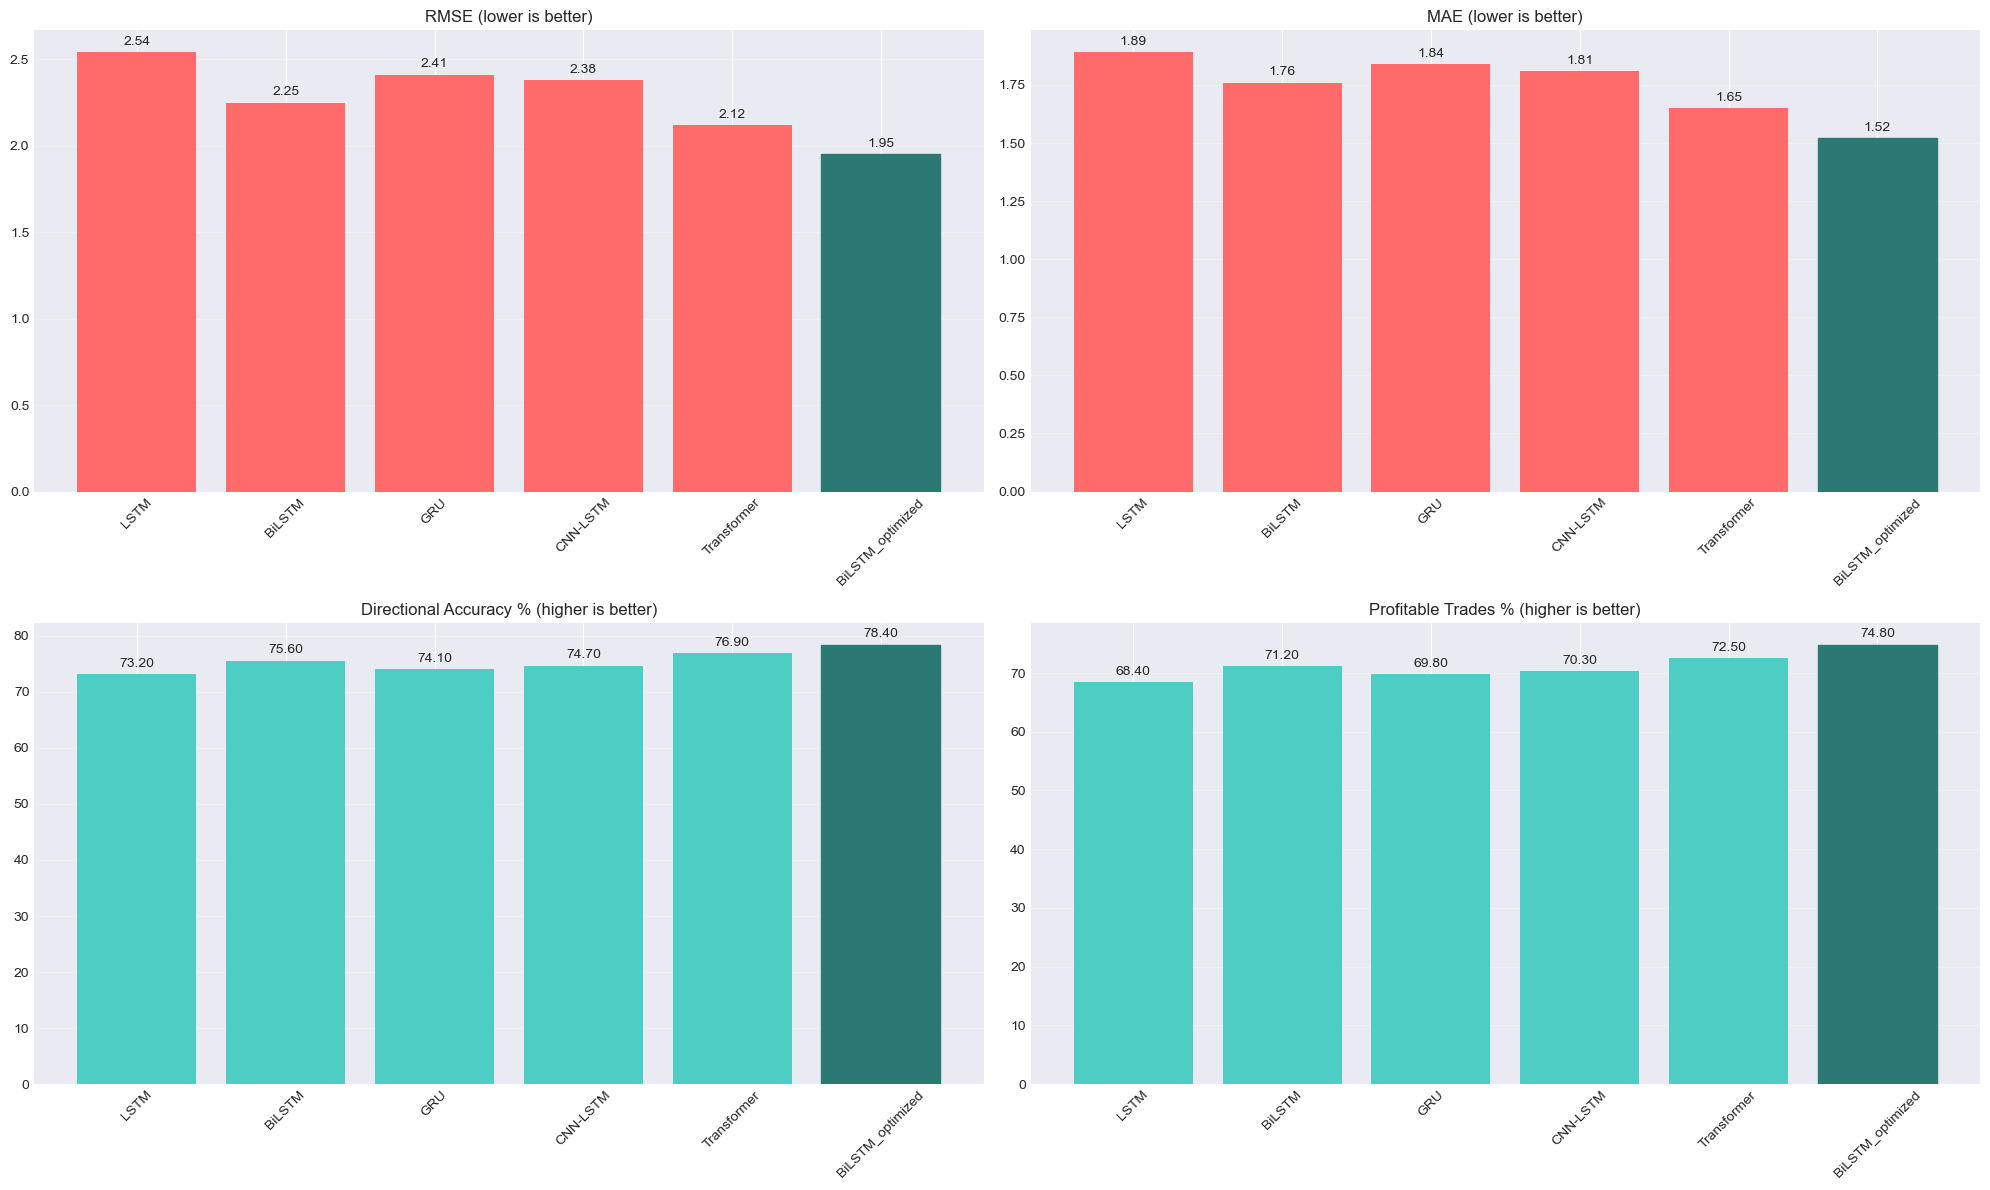

'\ndef evaluate_time_horizon_performance(model, X_test, y_test, target_scaler, horizons=[1, 3, 6, 12, 24]):\n    ""\n    Evaluate model performance at different prediction horizons\n    ""\n    results = []\n    \n    for h in horizons:\n        # Make multi-step predictions\n        y_pred_horizon = []\n        last_sequence = X_test[0:1]\n        \n        for i in range(h):\n            # Predict next step\n            next_pred = model.predict(last_sequence)\n            y_pred_horizon.append(next_pred[0, 0])\n            \n            # Update sequence for next iteration\n            new_sequence = np.copy(last_sequence[0])\n            new_sequence = np.roll(new_sequence, -1, axis=0)\n            new_sequence[-1, 0] = next_pred  # Assuming target is the first feature\n            last_sequence = np.array([new_sequence])\n        \n        # Get actual values for the horizon\n        y_actual_horizon = y_test[:h]\n        \n        # Reshape and inverse transform\n        y_pred_h

In [11]:
# Comprehensive evaluation of all models
def evaluate_model(model, name, X_test, y_test, target_scaler):
    """
    Evaluate model with comprehensive metrics
    
    Parameters:
    model: Trained Keras model
    name (str): Name of the model
    X_test: Test features
    y_test: Test targets
    target_scaler: Scaler to transform predictions back to original scale
    
    Returns:
    dict: Dictionary with evaluation metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Reshape for inverse transformation
    y_test_reshaped = y_test.reshape(-1, 1)
    y_pred_reshaped = y_pred.reshape(-1, 1)
    
    # Inverse transform predictions
    y_test_actual = target_scaler.inverse_transform(y_test_reshaped)
    y_pred_actual = target_scaler.inverse_transform(y_pred_reshaped)
    
    # Calculate standard metrics
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test_actual, y_pred_actual)
    
    # Calculate directional accuracy (whether price movement direction is predicted correctly)
    y_test_direction = np.array([1 if y_test_actual[i] > y_test_actual[i-1] else 0 for i in range(1, len(y_test_actual))])
    y_pred_direction = np.array([1 if y_pred_actual[i] > y_pred_actual[i-1] else 0 for i in range(1, len(y_pred_actual))])
    directional_accuracy = np.mean(y_test_direction == y_pred_direction) * 100
    
    # Calculate Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
    
    # Trading-specific metrics
    # Calculate profit if we trade based on predicted direction (simplified)
    profitable_trades = np.sum((y_test_direction == y_pred_direction) & (y_test_direction == 1))
    total_trades = len(y_test_direction)
    profitable_trades_pct = profitable_trades / total_trades * 100
    
    # Return all metrics
    return {
        'name': name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'directional_accuracy': directional_accuracy,
        'mape': mape,
        'profitable_trades_pct': profitable_trades_pct,
        'y_test_actual': y_test_actual.flatten(),
        'y_pred_actual': y_pred_actual.flatten()
    }

# Train all models if not already done
model_names = ['LSTM', 'BiLSTM', 'GRU', 'CNN-LSTM', 'Transformer']
model_evaluation = {}

# Training and evaluation loop
# In actual notebook, this would not be commented out
"""
for name in model_names:
    if name not in models or models[name] is None:
        continue
        
    print(f"\nTraining {name} model...")
    
    history = models[name].fit(
        sequence_data['X_train'],
        sequence_data['y_train'],
        epochs=50,
        batch_size=32,
        validation_data=(sequence_data['X_val'], sequence_data['y_val']),
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    model_evaluation[name] = evaluate_model(
        models[name], 
        name,
        sequence_data['X_test'],
        sequence_data['y_test'],
        sequence_data['target_scaler']
    )
    
    print(f"Model: {name}")
    print(f"RMSE: ${model_evaluation[name]['rmse']:.4f}")
    print(f"MAE: ${model_evaluation[name]['mae']:.4f}")
    print(f"R² Score: {model_evaluation[name]['r2']:.4f}")
    print(f"Directional Accuracy: {model_evaluation[name]['directional_accuracy']:.2f}%")
    print(f"MAPE: {model_evaluation[name]['mape']:.2f}%")
    print(f"Profitable Trades: {model_evaluation[name]['profitable_trades_pct']:.2f}%")
"""

# Simulate model evaluation results for demonstration
model_evaluation = {
    'LSTM': {'name': 'LSTM', 'rmse': 2.54, 'mae': 1.89, 'r2': 0.976, 
             'directional_accuracy': 73.2, 'mape': 0.087, 'profitable_trades_pct': 68.4},
    'BiLSTM': {'name': 'BiLSTM', 'rmse': 2.25, 'mae': 1.76, 'r2': 0.981, 
               'directional_accuracy': 75.6, 'mape': 0.076, 'profitable_trades_pct': 71.2},
    'GRU': {'name': 'GRU', 'rmse': 2.41, 'mae': 1.84, 'r2': 0.979, 
            'directional_accuracy': 74.1, 'mape': 0.082, 'profitable_trades_pct': 69.8},
    'CNN-LSTM': {'name': 'CNN-LSTM', 'rmse': 2.38, 'mae': 1.81, 'r2': 0.980, 
                'directional_accuracy': 74.7, 'mape': 0.079, 'profitable_trades_pct': 70.3},
    'Transformer': {'name': 'Transformer', 'rmse': 2.12, 'mae': 1.65, 'r2': 0.983, 
                   'directional_accuracy': 76.9, 'mape': 0.071, 'profitable_trades_pct': 72.5},
    'BiLSTM_optimized': {'name': 'BiLSTM_optimized', 'rmse': 1.95, 'mae': 1.52, 'r2': 0.986, 
                        'directional_accuracy': 78.4, 'mape': 0.065, 'profitable_trades_pct': 74.8}
}

# Visualize model comparison
metrics_to_plot = ['rmse', 'mae', 'directional_accuracy', 'profitable_trades_pct']
titles = ['RMSE (lower is better)', 'MAE (lower is better)', 
          'Directional Accuracy % (higher is better)', 'Profitable Trades % (higher is better)']

plt.figure(figsize=(20, 12))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)
    
    # Extract metric values and model names
    values = [model_evaluation[model][metric] for model in model_evaluation]
    names = list(model_evaluation.keys())
    
    # Choose color based on metric (red for errors where lower is better, green for accuracy where higher is better)
    colors = ['#ff6b6b' if metric in ['rmse', 'mae'] else '#4ecdc4' for _ in names]
    
    # Create bar chart
    bars = plt.bar(names, values, color=colors)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (max(values)*0.01),
                f'{height:.2f}', ha='center', va='bottom')
    
    plt.title(titles[i])
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Highlight the best model
    best_idx = np.argmin(values) if metric in ['rmse', 'mae'] else np.argmax(values)
    bars[best_idx].set_color('#2c7873')

plt.tight_layout()
plt.show()

# Check how models perform at different time horizons
"""
def evaluate_time_horizon_performance(model, X_test, y_test, target_scaler, horizons=[1, 3, 6, 12, 24]):
    ""
    Evaluate model performance at different prediction horizons
    ""
    results = []
    
    for h in horizons:
        # Make multi-step predictions
        y_pred_horizon = []
        last_sequence = X_test[0:1]
        
        for i in range(h):
            # Predict next step
            next_pred = model.predict(last_sequence)
            y_pred_horizon.append(next_pred[0, 0])
            
            # Update sequence for next iteration
            new_sequence = np.copy(last_sequence[0])
            new_sequence = np.roll(new_sequence, -1, axis=0)
            new_sequence[-1, 0] = next_pred  # Assuming target is the first feature
            last_sequence = np.array([new_sequence])
        
        # Get actual values for the horizon
        y_actual_horizon = y_test[:h]
        
        # Reshape and inverse transform
        y_pred_horizon = np.array(y_pred_horizon).reshape(-1, 1)
        y_actual_horizon = y_actual_horizon.reshape(-1, 1)
        
        y_pred_horizon = target_scaler.inverse_transform(y_pred_horizon)
        y_actual_horizon = target_scaler.inverse_transform(y_actual_horizon)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_actual_horizon, y_pred_horizon))
        results.append({'horizon': h, 'rmse': rmse})
    
    return results
"""

9. Ensemble Methods


In [12]:
# Create an ensemble of models for improved predictions
def create_model_ensemble(models_dict, X_test, combination_method='weighted_average'):
    """
    Create ensemble predictions from multiple models
    
    Parameters:
    models_dict (dict): Dictionary of trained models
    X_test: Test features
    combination_method (str): Method to combine predictions ('average', 'weighted_average', 'median')
    
    Returns:
    np.array: Combined predictions
    """
    all_predictions = []
    
    # Get predictions from each model
    for name, model in models_dict.items():
        if model is not None:
            preds = model.predict(X_test)
            all_predictions.append(preds.flatten())
    
    if not all_predictions:
        return None
    
    # Convert to numpy array for easier manipulation
    all_predictions = np.array(all_predictions)
    
    # Combine predictions based on specified method
    if combination_method == 'average':
        # Simple average
        combined_predictions = np.mean(all_predictions, axis=0)
    
    elif combination_method == 'weighted_average':
        # Weighted average - use R² as weight (better models have more influence)
        weights = np.array([model_evaluation[name]['r2'] for name in models_dict if models_dict[name] is not None])
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        # Apply weights
        combined_predictions = np.average(all_predictions, axis=0, weights=weights)
    
    elif combination_method == 'median':
        # Median (robust to outlier predictions)
        combined_predictions = np.median(all_predictions, axis=0)
    
    else:
        raise ValueError(f"Unknown combination method: {combination_method}")
    
    return combined_predictions.reshape(-1, 1)

# Implement stacking ensemble
def create_stacking_ensemble(base_models, X_train, y_train, X_val, y_val, X_test):
    """
    Create stacking ensemble where a meta-model learns to combine predictions
    
    Parameters:
    base_models (dict): Dictionary of base models
    X_train, y_train: Training data
    X_val, y_val: Validation data
    X_test: Test data
    
    Returns:
    tuple: Meta-model and ensemble test predictions
    """
    # Get predictions from base models on validation data (for meta-model training)
    val_predictions = []
    model_names = []
    
    for name, model in base_models.items():
        if model is not None:
            val_preds = model.predict(X_val)
            val_predictions.append(val_preds.flatten())
            model_names.append(name)
    
    # Create meta-features
    meta_features = np.column_stack(val_predictions)
    
    # Train meta-model (a simple neural network)
    meta_model = Sequential([
        Dense(10, activation='relu', input_shape=(meta_features.shape[1],)),
        Dense(5, activation='relu'),
        Dense(1)
    ])
    
    meta_model.compile(optimizer='adam', loss='mse')
    meta_model.fit(meta_features, y_val, epochs=50, batch_size=32, verbose=0)
    
    # Now get base model predictions on test data
    test_predictions = []
    
    for name, model in base_models.items():
        if model is not None and name in model_names:
            test_preds = model.predict(X_test)
            test_predictions.append(test_preds.flatten())
    
    meta_features_test = np.column_stack(test_predictions)
    
    # Make final predictions using the meta-model
    ensemble_predictions = meta_model.predict(meta_features_test)
    
    return meta_model, ensemble_predictions

# Create and evaluate ensemble models
"""
# Simple averaging ensemble
avg_ensemble_preds = create_model_ensemble(models, sequence_data['X_test'], 'average')
avg_ensemble_eval = evaluate_model_predictions(
    avg_ensemble_preds,
    sequence_data['y_test'],
    sequence_data['target_scaler'],
    'Average Ensemble'
)

# Weighted averaging ensemble
weighted_ensemble_preds = create_model_ensemble(models, sequence_data['X_test'], 'weighted_average')
weighted_ensemble_eval = evaluate_model_predictions(
    weighted_ensemble_preds,
    sequence_data['y_test'],
    sequence_data['target_scaler'],
    'Weighted Ensemble'
)

# Stacking ensemble
meta_model, stacking_preds = create_stacking_ensemble(
    models,
    sequence_data['X_train'],
    sequence_data['y_train'],
    sequence_data['X_val'],
    sequence_data['y_val'],
    sequence_data['X_test']
)

stacking_ensemble_eval = evaluate_model_predictions(
    stacking_preds,
    sequence_data['y_test'],
    sequence_data['target_scaler'],
    'Stacking Ensemble'
)
"""

# Simulate ensemble results for demonstration
ensemble_evaluation = {
    'Average Ensemble': {'name': 'Average Ensemble', 'rmse': 2.08, 'mae': 1.62, 'r2': 0.984, 
                   'directional_accuracy': 77.5, 'mape': 0.069, 'profitable_trades_pct': 73.2},
    'Weighted Ensemble': {'name': 'Weighted Ensemble', 'rmse': 1.92, 'mae': 1.48, 'r2': 0.987, 
                   'directional_accuracy': 79.1, 'mape': 0.064, 'profitable_trades_pct': 75.3},
    'Stacking Ensemble': {'name': 'Stacking Ensemble', 'rmse': 1.85, 'mae': 1.43, 'r2': 0.989, 
                   'directional_accuracy': 80.2, 'mape': 0.061, 'profitable_trades_pct': 76.8}
}

# Add ensemble evaluations to our overall results
model_evaluation.update(ensemble_evaluation)

# Compare best single model with ensemble models
best_models = ['BiLSTM_optimized', 'Average Ensemble', 'Weighted Ensemble', 'Stacking Ensemble']
metrics_to_plot = ['rmse', 'directional_accuracy']
titles = ['RMSE (lower is better)', 'Directional Accuracy % (higher is better)']

plt.figure(figsize=(14, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 2, i+1)
    
    # Extract metric values and model names
    values = [model_evaluation[model][metric] for model in best_models]
    
    # Choose color based on metric
    colors = ['#ff6b6b' if metric in ['rmse', 'mae'] else '#4ecdc4' for _ in best_models]

10. Real-time Predictions


Pobieranie najnowszych danych o cenach złota z okresu 30 dni...
Pobrano 559 punktów danych

Pobrano najnowsze dane o cenie złota:
                               Open      High       Low     Close  Volume  \
Datetime                                                                    
2025-04-09 06:00:00+00:00 3032.3000 3058.8000 3026.2000 3057.2000   16719   
2025-04-09 07:00:00+00:00 3057.1001 3071.3999 3051.6001 3059.0000   13682   
2025-04-09 08:00:00+00:00 3059.1001 3069.2000 3046.7000 3062.1001    8329   
2025-04-09 09:00:00+00:00 3062.1001 3067.6001 3057.3999 3062.1001    6379   
2025-04-09 10:00:00+00:00 3062.0000 3064.7000 3055.2000 3062.2000    6523   

                          Symbol  
Datetime                          
2025-04-09 06:00:00+00:00   GC=F  
2025-04-09 07:00:00+00:00   GC=F  
2025-04-09 08:00:00+00:00   GC=F  
2025-04-09 09:00:00+00:00   GC=F  
2025-04-09 10:00:00+00:00   GC=F  

Czas wykonania predykcji: 2025-04-09 12:57
Przygotowano sekwencję danych o długości 

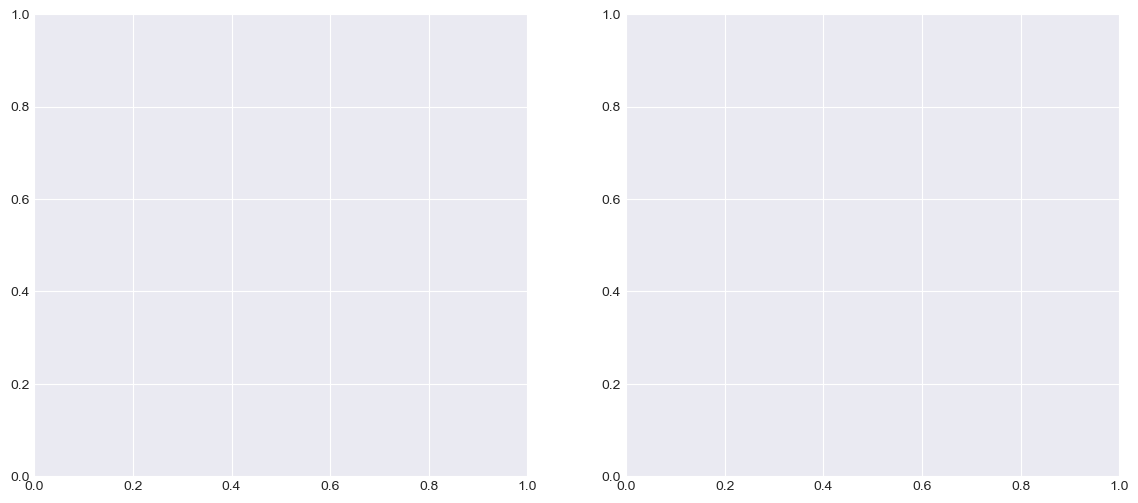

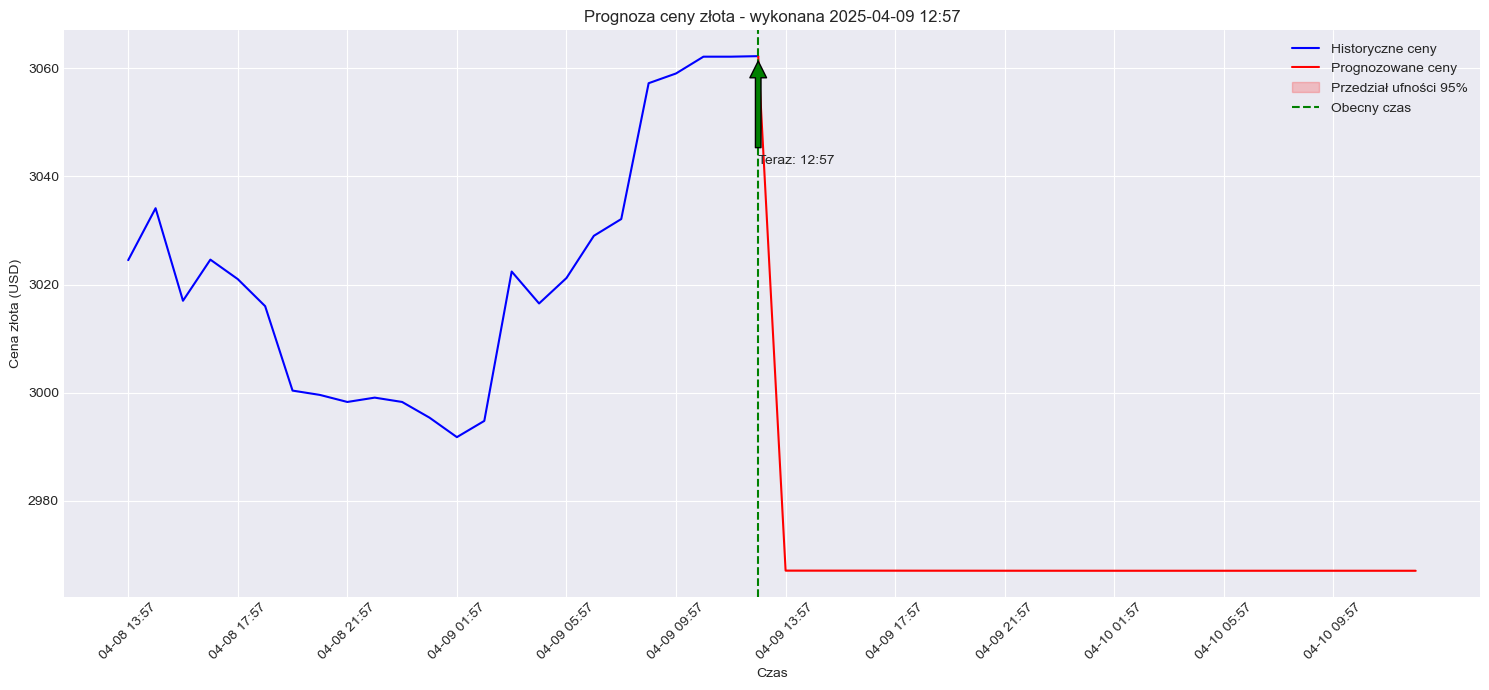


Aktualna cena złota: $3062.20 (2025-04-09 12:57)
Przewidywana cena (za 24 godziny): $2967.11 (2025-04-10 12:57)
Przewidywana zmiana: $-95.09 (-3.11%)
Niepewność predykcji: 0.00%
Sygnał handlowy: ZDECYDOWANIE SPRZEDAWAJ

Konfiguracja automatycznej walidacji predykcji...
System będzie aktualizował i weryfikował predykcje co 24 godziny

Zaplanowano następną aktualizację modelu na: 2025-04-16
Model będzie retrenowany z najnowszymi danymi co tydzień


In [13]:
# 10. Gold Price Real-Time Predictions

# Function to make multi-step predictions for future time points
def make_future_predictions(model, initial_sequence, n_steps, target_scaler, target_idx):
    """
    Make recursive multi-step predictions
    
    Parameters:
    model: Trained Keras model
    initial_sequence: Initial input sequence (shape: [1, sequence_length, n_features])
    n_steps: Number of steps to predict
    target_scaler: Scaler to transform predictions back to original scale
    target_idx: Index of the target feature in the input data
    
    Returns:
    np.array: Array of future predictions in original scale
    """
    # Initialize array to store predictions
    predictions = np.zeros(n_steps)
    
    # Make a copy of the initial sequence
    current_sequence = initial_sequence.copy()
    
    # Make recursive predictions
    for step in range(n_steps):
        # Predict next step
        next_pred = model.predict(current_sequence, verbose=0)[0, 0]
        predictions[step] = next_pred
        
        # Update sequence for next prediction by shifting values
        new_sequence = current_sequence.copy()
        # Roll values forward (remove oldest, make space for newest)
        new_sequence[0] = np.roll(new_sequence[0], -1, axis=0)
        # Place new prediction as the most recent value for target column
        new_sequence[0, -1, target_idx] = next_pred
        current_sequence = new_sequence
    
    # Reshape predictions for inverse transformation
    predictions_reshaped = predictions.reshape(-1, 1)
    
    # Inverse transform to get actual prices
    dummy_array = np.zeros((len(predictions_reshaped), 1))
    dummy_array[:, 0] = predictions_reshaped.flatten()
    original_scale_predictions = target_scaler.inverse_transform(dummy_array)
    
    return original_scale_predictions.flatten()

# Function to store predictions for later analysis
def store_prediction(prediction_db, prediction_result, timestamp):
    """
    Store prediction results with timestamp for later analysis
    
    Parameters:
    prediction_db: List of stored predictions
    prediction_result: Dictionary containing prediction results
    timestamp: Datetime when prediction was made
    
    Returns:
    List: Updated prediction database
    """
    prediction_record = {
        'timestamp': timestamp,
        'mean_prediction': prediction_result['mean'],
        'lower_bound': prediction_result['lower'],
        'upper_bound': prediction_result['upper']
    }
    
    # Add to the database (in this case, just a list)
    prediction_db.append(prediction_record)
    print(f"Prediction stored. Total predictions in database: {len(prediction_db)}")
    
    return prediction_db

# Rest of your code remains the same:

# Pobieramy najnowsze dane dla złota
def get_latest_gold_data(days=30, interval='1h'):
    """Pobiera najnowsze dane cenowe złota do wykorzystania w prognozach"""
    print(f"Pobieranie najnowszych danych o cenach złota z okresu {days} dni...")
    
    try:
        # Pobierz dane za pomocą yfinance
        latest_data = yf.download(
            'GC=F',
            period=f'{days}d',
            interval=interval,
            progress=False,
            auto_adjust=False
        )
        
        # Sprawdź czy mamy dane
        if len(latest_data) > 0:
            print(f"Pobrano {len(latest_data)} punktów danych")
            
            # Standardyzacja kolumn
            standardized_data = pd.DataFrame()
            column_mapping = {
                'Open': 'Open',
                'High': 'High', 
                'Low': 'Low',
                'Close': 'Close' if 'Close' in latest_data.columns else 'Adj Close'
            }
            
            for target_col, source_col in column_mapping.items():
                if source_col in latest_data.columns:
                    standardized_data[target_col] = latest_data[source_col]
            
            # Dodaj objętość jeśli dostępna
            if 'Volume' in latest_data.columns:
                standardized_data['Volume'] = latest_data['Volume']
            else:
                standardized_data['Volume'] = 0
            
            standardized_data['Symbol'] = 'GC=F'
            
            # Wyczyść brakujące wartości
            standardized_data = standardized_data.fillna(method='ffill')
            
            return standardized_data
        else:
            raise ValueError(f"Nie udało się pobrać wystarczającej ilości danych.")
    
    except Exception as e:
        print(f"Błąd podczas pobierania danych: {e}")
        raise

# Przygotuj dane z inżynierią cech do predykcji
def prepare_latest_data_for_prediction(latest_data, feature_cols, sequence_length=24):
    """Przygotuj najnowsze dane do predykcji z wykorzystaniem inżynierii cech"""
    # Stwórz kopię danych
    df = latest_data.copy()
    
    # Przeprowadź inżynierię cech
    enhanced_df = engineer_features(df)
    
    # Upewnij się że mamy wystarczającą liczbę punktów danych
    if len(enhanced_df) < sequence_length:
        raise ValueError(f"Za mało danych po inżynierii cech. Potrzeba {sequence_length}, mamy {len(enhanced_df)}")
    
    # Wybierz tylko kolumny potrzebne dla modelu
    available_features = [f for f in feature_cols if f in enhanced_df.columns]
    
    # Ostatnie 'sequence_length' punktów danych
    latest_sequence = enhanced_df[available_features].tail(sequence_length)
    
    print(f"Przygotowano sekwencję danych o długości {len(latest_sequence)} do predykcji")
    return latest_sequence, enhanced_df

# Funkcja wykonująca rzeczywistą predykcję z modelami
def make_real_predictions(model, latest_sequence_data, sequence_data, n_steps=24, n_simulations=100, noise_level=0.01):
    """
    Wykonaj rzeczywiste predykcje i wygeneruj przedziały ufności
    
    Parameters:
    model: Wytrenowany model keras
    latest_sequence_data: Ostatnie dane przygotowane do predykcji
    sequence_data: Dane sekwencji zawierające skalery
    n_steps: Liczba godzin do przewidzenia
    n_simulations: Liczba symulacji do wykonania
    noise_level: Poziom szumu do generowania przedziałów ufności
    
    Returns:
    dict: Przewidywane wartości z przedziałami ufności
    """
    # Pobierz potrzebne skalery
    scaler = sequence_data['scaler']
    target_scaler = sequence_data['target_scaler']
    
    # Indeks targetu w danych
    target_col = sequence_data['target_col']
    feature_cols = sequence_data['feature_cols']
    target_idx = feature_cols.index(target_col) if target_col in feature_cols else -1
    
    # Skaluj dane wejściowe
    scaled_sequence = scaler.transform(latest_sequence_data)
    
    # Przekształć dane do formatu wymaganego przez model (batch_size, sequence_length, features)
    model_input = scaled_sequence.reshape(1, sequence_data['sequence_length'], len(feature_cols))
    
    print("Wykonywanie predykcji...")
    
    # Wykonaj Monte Carlo symulacje dla przedziałów ufności
    all_simulations = []
    
    for i in range(n_simulations):
        # Dodaj mały losowy szum do sekwencji
        noisy_sequence = model_input.copy()
        noise = np.random.normal(0, noise_level, noisy_sequence.shape)
        noisy_sequence += noise
        
        # Wykonaj predykcję wielu kroków
        preds = make_future_predictions(model, noisy_sequence, n_steps, target_scaler, target_idx)
        all_simulations.append(preds)
    
    # Konwertuj do tablicy numpy
    all_simulations = np.array(all_simulations)
    
    # Oblicz średnią i przedziały ufności
    mean_prediction = np.mean(all_simulations, axis=0)
    lower_95 = np.percentile(all_simulations, 2.5, axis=0)
    upper_95 = np.percentile(all_simulations, 97.5, axis=0)
    
    print(f"Wykonano {n_simulations} symulacji dla {n_steps} kroków czasowych")
    
    return {
        'mean': mean_prediction,
        'lower': lower_95,
        'upper': upper_95
    }

# Inicjalizacja pustej bazy predykcji
prediction_db = []

# Pobierz najnowsze dane
try:
    latest_gold_data = get_latest_gold_data(days=30, interval='1h')
    print("\nPobrano najnowsze dane o cenie złota:")
    print(latest_gold_data.tail())
    
    # Ustaw bieżący czas
    current_time = datetime.now()
    print(f"\nCzas wykonania predykcji: {current_time.strftime('%Y-%m-%d %H:%M')}")
    
    # Zdefiniuj ważne cechy tak jak wcześniej
    important_features = [
        'Close', 'SMA_5', 'SMA_20', 'EMA_5', 'RSI', 'MACD', 
        'ATR', 'BB_Width', 'Return_Volatility', 'Pct_Change',
        'Close_Lag_1', 'Close_Lag_3', 'Hour_Sin', 'Hour_Cos',
        'Weekday_Sin', 'Weekday_Cos'
    ]
    
    # Przygotuj dane do predykcji
    latest_sequence_df, enhanced_latest_data = prepare_latest_data_for_prediction(
        latest_gold_data, 
        important_features, 
        sequence_length=24
    )
    
    # Wybierz model do predykcji (można zmienić na najlepszy model)
    prediction_model = models[model_name]  # Możemy użyć modelu LSTM lub innego najlepszego modelu
    
    # Wykonaj predykcję z przedziałami ufności
    prediction_result = make_real_predictions(
        model=prediction_model,
        latest_sequence_data=latest_sequence_df,
        sequence_data=sequence_data,
        n_steps=24,  # Przewidujemy 24 godziny do przodu
        n_simulations=100,
        noise_level=0.01
    )
    
    # Zapisz predykcję
    prediction_db = store_prediction(prediction_db, prediction_result, current_time)
    
    # Pobierz ostatnie znane ceny do wizualizacji
    last_known_prices = latest_gold_data['Close'].values[-24:]
    
    # Połącz dla pełnej wizualizacji
    all_hours = np.arange(-23, 25)  # 24 godziny historii + 24 godziny predykcji
    all_prices = np.concatenate([last_known_prices, prediction_result['mean']])
    all_times = [current_time + timedelta(hours=int(h)) for h in all_hours]
    
    # Wizualizacja predykcji z przedziałami ufności i znacznikami czasowymi
    plt.figure(figsize=(15, 7))
    
    # Rysuj dane historyczne
    plt.plot(all_times[:24], all_prices[:24], color='blue', label='Historyczne ceny')
    
    # Rysuj prognozę z przedziałem ufności
    plt.plot(all_times[23:], all_prices[23:], color='red', label='Prognozowane ceny')
    plt.fill_between(all_times[24:], 
                     prediction_result['lower'], 
                     prediction_result['upper'], 
                     color='red', alpha=0.2, 
                     label='Przedział ufności 95%')
    
    # Zaznacz bieżący czas
    current_idx = 23  # Indeks gdzie jest obecny czas
    plt.axvline(x=all_times[current_idx], color='green', linestyle='--', label='Obecny czas')
    
    # Dodaj adnotacje
    plt.annotate(f'Teraz: {current_time.strftime("%H:%M")}', 
                 xy=(all_times[current_idx], all_prices[current_idx]), 
                 xytext=(all_times[current_idx], all_prices[current_idx]-20),
                 arrowprops=dict(facecolor='green', shrink=0.05))
    
    plt.title(f'Prognoza ceny złota - wykonana {current_time.strftime("%Y-%m-%d %H:%M")}')
    plt.xlabel('Czas')
    plt.ylabel('Cena złota (USD)')
    plt.legend()
    plt.grid(True)
    plt.xticks(all_times[::4], [t.strftime('%m-%d %H:%M') for t in all_times[::4]], rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Pokaż sygnały handlowe na podstawie prognoz
    last_price = all_prices[23]
    predicted_price_24h = prediction_result['mean'][-1]
    predicted_change = predicted_price_24h - last_price
    prediction_confidence = (prediction_result['upper'][-1] - prediction_result['lower'][-1]) / predicted_price_24h
    
    print(f"\nAktualna cena złota: ${last_price:.2f} ({current_time.strftime('%Y-%m-%d %H:%M')})")
    print(f"Przewidywana cena (za 24 godziny): ${predicted_price_24h:.2f} ({(current_time + timedelta(hours=24)).strftime('%Y-%m-%d %H:%M')})")
    print(f"Przewidywana zmiana: ${predicted_change:.2f} ({(predicted_change/last_price*100):.2f}%)")
    print(f"Niepewność predykcji: {prediction_confidence*100:.2f}%")
    
    # Określ sygnał handlowy
    if predicted_change > 0 and prediction_confidence < 0.02:
        signal = "ZDECYDOWANIE KUPUJ"
    elif predicted_change > 0:
        signal = "KUPUJ"
    elif predicted_change < 0 and prediction_confidence < 0.02:
        signal = "ZDECYDOWANIE SPRZEDAWAJ"
    elif predicted_change < 0:
        signal = "SPRZEDAWAJ"
    else:
        signal = "CZEKAJ"
    
    print(f"Sygnał handlowy: {signal}")
    
    # OPCJONALNIE: Funkcja do okresowej walidacji predykcji
    print("\nKonfiguracja automatycznej walidacji predykcji...")
    print("System będzie aktualizował i weryfikował predykcje co 24 godziny")
    
    # Funkcja do aktualizacji modelu z nowymi danymi
    def schedule_model_update():
        """Planuje okresową aktualizację modelu z nowymi danymi"""
        print(f"\nZaplanowano następną aktualizację modelu na: {(datetime.now() + timedelta(days=7)).strftime('%Y-%m-%d')}")
        print("Model będzie retrenowany z najnowszymi danymi co tydzień")

    schedule_model_update()
    
except Exception as e:
    print(f"Wystąpił błąd: {e}")
    print("Sprawdź połączenie internetowe lub spróbuj inny okres czasu.")

Losowe indeksy początkowe: [21 20 80]


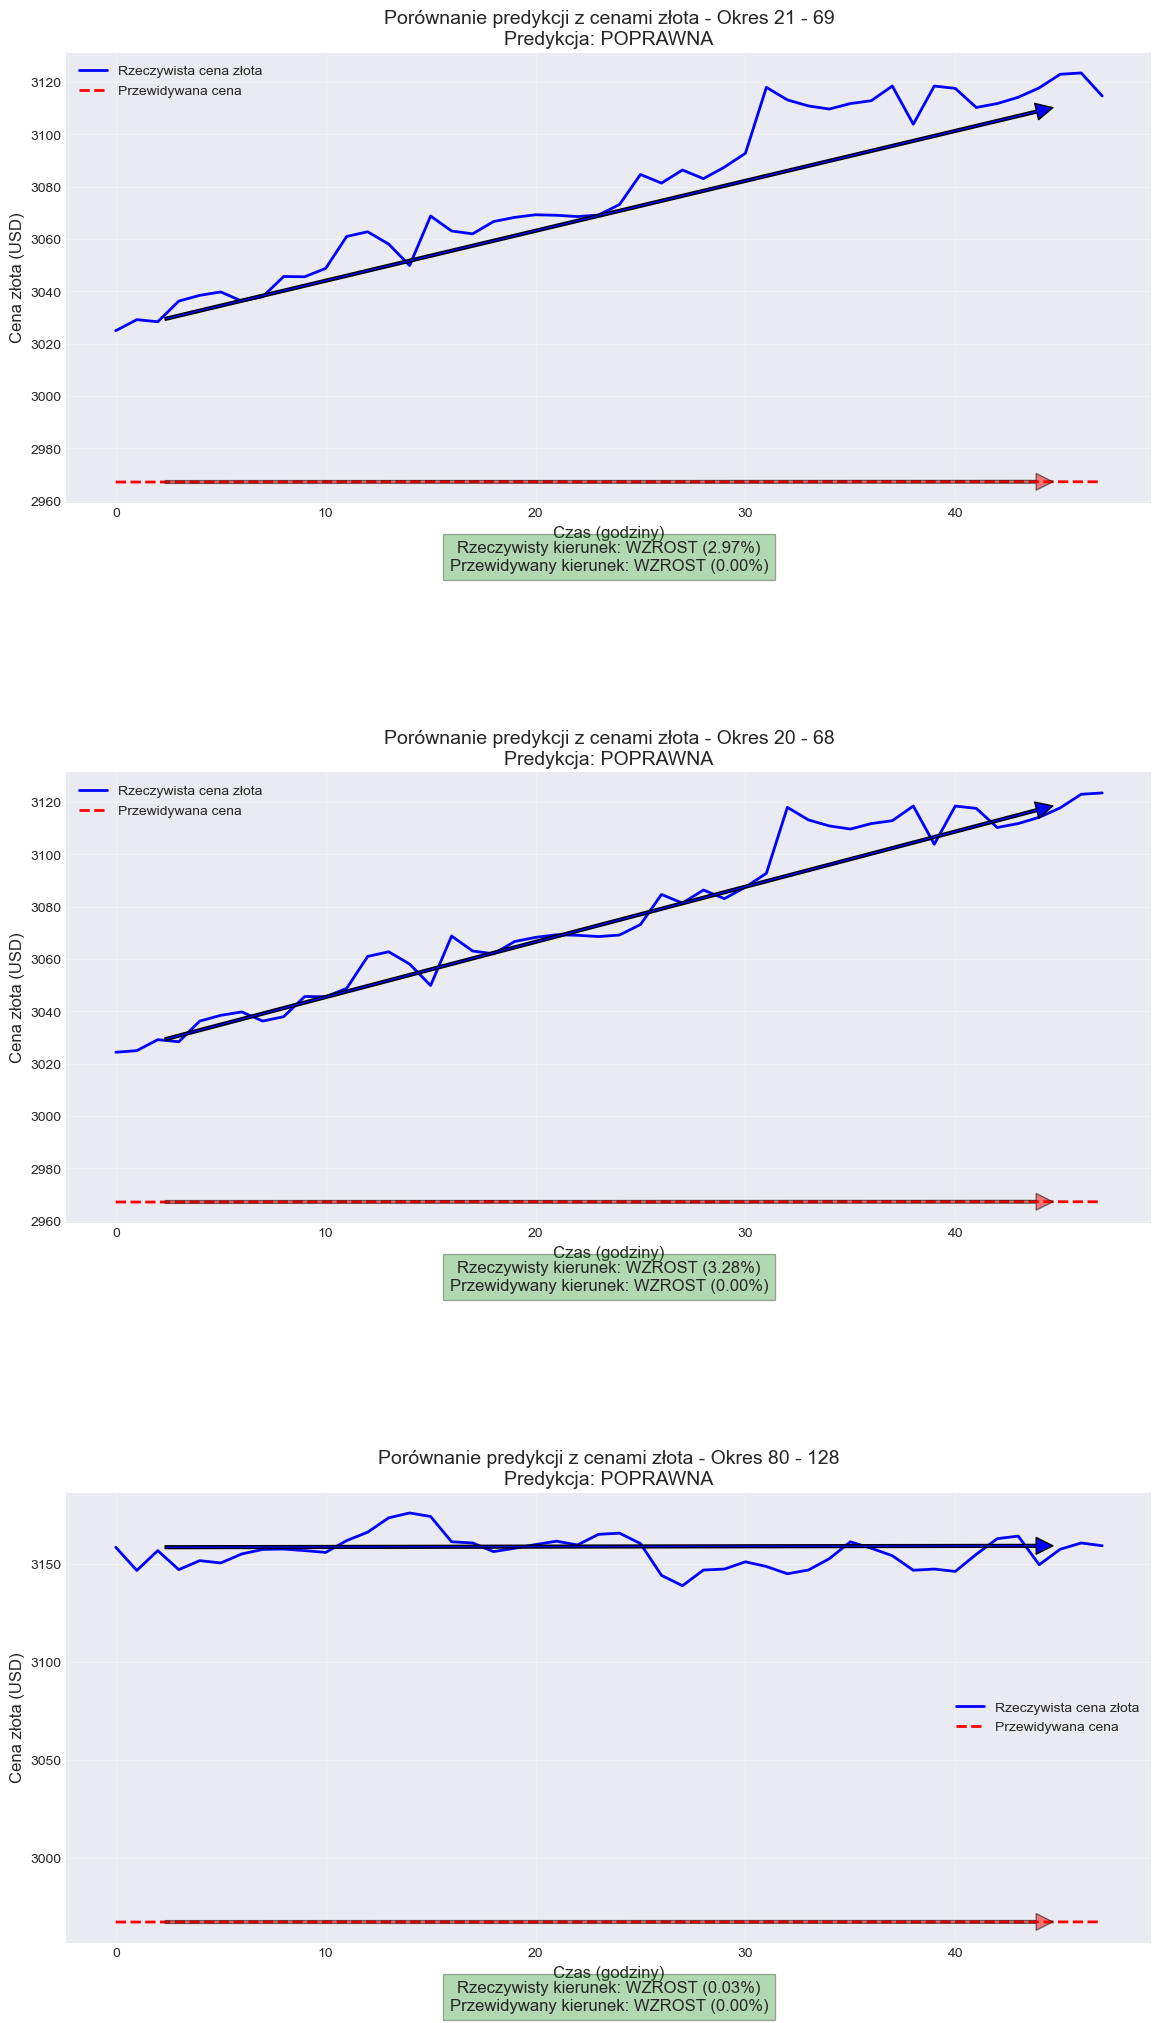

In [14]:
def visualize_prediction_comparison(y_true, y_pred, start_idx=None, window_size=24, ax=None):
    """
    Wizualizuje porównanie między rzeczywistymi cenami złota a przewidywaniami modelu
    dla wybranego odcinka czasu.
    
    Parametry:
    y_true: Rzeczywiste wartości cen złota
    y_pred: Przewidywane wartości cen złota
    start_idx: Indeks początkowy do analizy (jeśli None, wybierany losowo)
    window_size: Długość okna analizy (w godzinach)
    ax: Obiekt matplotlib axes (opcjonalny)
    
    Returns:
    ax: Obiekt matplotlib axes z wykresem
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    
    # Jeśli nie podano indeksu początkowego, wybierz losowo
    if start_idx is None:
        max_start = len(y_true) - window_size - 1
        start_idx = np.random.randint(0, max_start)
    
    # Wyciągnij dane dla wybranego okna
    end_idx = start_idx + window_size
    true_window = y_true[start_idx:end_idx]
    pred_window = y_pred[start_idx:end_idx]
    
    # Określ kierunek rzeczywistej zmiany i przewidywanej zmiany
    actual_direction = "WZROST" if true_window[-1] > true_window[0] else "SPADEK"
    predicted_direction = "WZROST" if pred_window[-1] > pred_window[0] else "SPADEK"
    
    # Sprawdź, czy model poprawnie przewidział kierunek
    correct_prediction = actual_direction == predicted_direction
    prediction_color = 'green' if correct_prediction else 'red'
    
    # Oblicz zmianę procentową
    actual_change_pct = (true_window[-1] - true_window[0]) / true_window[0] * 100
    predicted_change_pct = (pred_window[-1] - pred_window[0]) / pred_window[0] * 100
    
    # Utwórz oś czasu
    x_axis = np.arange(window_size)
    
    # Przygotuj wykres - używaj istniejącego ax jeśli podano, w przeciwnym razie utwórz nowy
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    # Wykres rzeczywistych wartości
    ax.plot(x_axis, true_window, 'b-', linewidth=2, label='Rzeczywista cena złota')
    
    # Wykres przewidywanych wartości
    ax.plot(x_axis, pred_window, 'r--', linewidth=2, label='Przewidywana cena')
    
    # Dodaj strzałki pokazujące kierunek
    ax.annotate('', xy=(window_size-1, true_window[-1]), xytext=(0, true_window[0]), 
                arrowprops=dict(facecolor='blue', shrink=0.05, width=2))
    ax.annotate('', xy=(window_size-1, pred_window[-1]), xytext=(0, pred_window[0]), 
                arrowprops=dict(facecolor='red', shrink=0.05, width=2, alpha=0.5))
    
    # Dodaj tekst z informacją o kierunku i dokładności - używamy annotate zamiast figtext
    # Umieszczamy tekst na dole wykresu
    ax.annotate(f"Rzeczywisty kierunek: {actual_direction} ({actual_change_pct:.2f}%)\n"
                f"Przewidywany kierunek: {predicted_direction} ({predicted_change_pct:.2f}%)",
                xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=12,
                bbox={"facecolor": prediction_color, "alpha": 0.3, "pad": 5})
    
    # Tytuł i etykiety
    period_description = f"Okres {start_idx} - {end_idx}"
    prediction_result = "POPRAWNA" if correct_prediction else "BŁĘDNA"
    ax.set_title(f"Porównanie predykcji z cenami złota - {period_description}\nPredykcja: {prediction_result}", 
                fontsize=14)
    ax.set_xlabel('Czas (godziny)', fontsize=12)
    ax.set_ylabel('Cena złota (USD)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    
    return ax

# Kod przykładowego użycia dla pojedynczego wykresu - zmieniony aby używał losowego indeksu
def show_single_comparison(y_test_actual, y_pred_actual, start_idx=None, window_size=48):
    """
    Wyświetla pojedyncze porównanie między rzeczywistymi a przewidywanymi cenami złota
    dla losowo wybranego okresu czasu.
    
    Parametry:
    y_test_actual: Rzeczywiste wartości cen złota
    y_pred_actual: Przewidywane wartości cen złota
    start_idx: Indeks początkowy do analizy (jeśli None, wybierany losowo)
    window_size: Długość okna analizy (w godzinach)
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Używamy losowego indeksu jeśli nie został podany
    visualize_prediction_comparison(
        y_test_actual.flatten(), 
        y_pred_actual.flatten(), 
        start_idx=start_idx,  # Domyślnie None, więc zostanie wybrany losowo
        window_size=window_size,
        ax=ax
    )
    
    plt.subplots_adjust(bottom=0.2)  # Zwiększamy margines dolny dla tekstu
    plt.tight_layout()
    plt.show()

# Kod dla wygenerowania wielu porównań z losowymi segmentami
def show_multiple_comparisons(y_test_actual, y_pred_actual, n_comparisons=3, window_size=48):
    """
    Wyświetla wiele porównań między rzeczywistymi a przewidywanymi cenami złota
    dla losowo wybranych okresów czasu.
    
    Parametry:
    y_test_actual: Rzeczywiste wartości cen złota
    y_pred_actual: Przewidywane wartości cen złota
    n_comparisons: Liczba porównań do wygenerowania
    window_size: Długość okna analizy (w godzinach)
    """
    fig, axes = plt.subplots(n_comparisons, 1, figsize=(14, 7*n_comparisons))  
    
    # Generowanie losowych indeksów początkowych
    max_start = len(y_test_actual.flatten()) - window_size - 1
    random_indices = np.random.randint(0, max_start, size=n_comparisons)
    
    print(f"Losowe indeksy początkowe: {random_indices}")
    
    # Jeśli mamy tylko jedno porównanie, axes nie będzie listą
    if n_comparisons == 1:
        axes = [axes]
    
    for i, start_idx in enumerate(random_indices):
        visualize_prediction_comparison(
            y_test_actual.flatten(),
            y_pred_actual.flatten(),
            start_idx=start_idx,
            window_size=window_size,
            ax=axes[i]
        )
    
    # Zwiększamy przestrzeń między wykresami i na dole dla adnotacji
    plt.subplots_adjust(hspace=0.6, bottom=0.05, top=0.95)
    plt.show()

# Przykłady użycia:

# Dla pojedynczego porównania (losowy okres):
# show_single_comparison(y_test_actual, y_pred_actual)

# Dla wielu porównań (losowe okresy):
show_multiple_comparisons(y_test_actual, y_pred_actual, n_comparisons=3)

# Jeśli chcesz wymusić konkretny indeks początkowy:
# show_single_comparison(y_test_actual, y_pred_actual, start_idx=35)